# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# magic word for producing visualizations in notebook
%matplotlib inline
pd.set_option('display.max_columns', None)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\AVELL\AppData\Local\Temp\ipykernel_9596\2693282953.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
C:\Users\AVELL\AppData\Local\Temp\ipykernel_9596\2693282953.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')


In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [4]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [5]:
# Let's check the difference between this 2 dataset.
set(azdias.columns)-set(customers.columns)

set()

In [6]:
set(customers.columns)-set(azdias.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

- The customers table has three more fields.

In [7]:
DIAS_attributes= pd.read_excel("DIAS Attributes - Values 2017.xlsx")

In [8]:
DIAS_attributes.shape

(2259, 5)

In [9]:
 DIAS_info=pd.read_excel("DIAS Information Levels - Attributes 2017.xlsx")

In [10]:
# Mark nan from the azdias data
DIAS_attributes.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Attribute,Description,Value,Meaning
1,NaN,AGER_TYP,best-ager typology,-1,unknown
2,NaN,NaN,NaN,0,no classification possible
3,NaN,NaN,NaN,1,passive elderly
4,NaN,NaN,NaN,2,cultural elderly


In [11]:
# clean the dataset
DIAS_attributes.drop(['Unnamed: 0'],axis=1,inplace=True)

In [12]:
if 'Attribute' in DIAS_attributes.iloc[0][0]:
    DIAS_attributes.drop(index=[0],axis=0,inplace=True)

In [13]:
DIAS_attributes.head()

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
1,AGER_TYP,best-ager typology,-1,unknown
2,NaN,NaN,0,no classification possible
3,NaN,NaN,1,passive elderly
4,NaN,NaN,2,cultural elderly
5,NaN,NaN,3,experience-driven elderly


In [14]:
DIAS_attributes.columns = ['Attribute','Description','Value','Meaning']

In [15]:
# fill in the attribute value.
attribute_name=''
# description_name=''
for i,v in DIAS_attributes.iterrows():
    if v['Attribute'] is np.nan:
        v['Attribute']=attribute_name
    else:
        attribute_name=v['Attribute']
#     if v['Description'] is np.nan:
#         v['Description']=description_name
#     else:
#         description_name=v['Description']

In [16]:
DIAS_attributes.head()

,Attribute,Description,Value,Meaning
1,AGER_TYP,best-ager typology,-1,unknown
2,AGER_TYP,NaN,0,no classification possible
3,AGER_TYP,NaN,1,passive elderly
4,AGER_TYP,NaN,2,cultural elderly
5,AGER_TYP,NaN,3,experience-driven elderly


In [17]:
# find out the attribute that value contains unknown.
missing_attribute_value_list=[]
for i,v in DIAS_attributes.iterrows():
    if v['Meaning'] is not np.nan:
        if 'unknown' in v['Meaning']:
            missing_attribute_value_list.append([v['Attribute'],v['Value'],v['Meaning']])

In [18]:
# find out the attribute that the data types are numerical.
numerical_attribute=set()
for i,v in DIAS_attributes.iterrows():
    if v['Meaning'] is not np.nan:
        if 'numeric' in v['Meaning']:
            numerical_attribute.add(v['Attribute'])

In [19]:
print(numerical_attribute)

{'MIN_GEBAEUDEJAHR', 'ANZ_HH_TITEL', 'KBA13_ANZAHL_PKW', 'GEBURTSJAHR', 'ANZ_TITEL', 'ANZ_PERSONEN', 'ANZ_HAUSHALTE_AKTIV'}


In [20]:
# find out the attricute that is no mention in the 2 dataset.
DIAS_attributes_name=set(DIAS_attributes['Attribute'].drop_duplicates())
DIAS_attributes_name-set(azdias.columns)

{'BIP_FLAG',
 'CAMEO_DEUINTL_2015',
 'D19_BANKEN_DIREKT_RZ',
 'D19_BANKEN_GROSS_RZ',
 'D19_BANKEN_LOKAL_RZ',
 'D19_BANKEN_REST_RZ',
 'D19_BEKLEIDUNG_GEH_RZ',
 'D19_BEKLEIDUNG_REST_RZ',
 'D19_BILDUNG_RZ',
 'D19_BIO_OEKO_RZ',
 'D19_BUCH_RZ',
 'D19_DIGIT_SERV_RZ',
 'D19_DROGERIEARTIKEL_RZ',
 'D19_ENERGIE_RZ',
 'D19_FREIZEIT_RZ',
 'D19_GARTEN_RZ',
 'D19_HANDWERK_RZ',
 'D19_HAUS_DEKO_RZ',
 'D19_KINDERARTIKEL_RZ',
 'D19_KK_KUNDENTYP',
 'D19_KOSMETIK_RZ',
 'D19_LEBENSMITTEL_RZ',
 'D19_LOTTO_RZ',
 'D19_NAHRUNGSERGAENZUNG_RZ',
 'D19_RATGEBER_RZ',
 'D19_REISEN_RZ',
 'D19_SAMMELARTIKEL_RZ',
 'D19_SCHUHE_RZ',
 'D19_SONSTIGE_RZ',
 'D19_TECHNIK_RZ',
 'D19_TELKO_MOBILE_RZ',
 'D19_TELKO_REST_RZ',
 'D19_TIERARTIKEL_RZ',
 'D19_VERSAND_REST_RZ',
 'D19_VERSICHERUNGEN_RZ',
 'D19_VOLLSORTIMENT_RZ',
 'D19_WEIN_FEINKOST_RZ',
 'GEOSCORE_KLS7',
 'HAUSHALTSSTRUKTUR',
 'KBA13_CCM_1400_2500',
 'SOHO_FLAG',
 'WACHSTUMSGEBIET_NB'}

- None of the above attributes mentioned

In [21]:
# find out the attribute that is no description.
set(azdias.columns)-DIAS_attributes_name

{'AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ARBEIT',
 'CAMEO_INTL_2015',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KONSUMTYP_MAX',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_SOZIALES',
 'D19_TECHNIK',
 'D19_TELKO_MOBILE',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_TELKO_REST',
 'D19_TIERARTIKEL',
 'D19_VERSAND_REST',
 'D19_VERSICHERUNGEN',
 '

- Lack of description of the above attributes

In [22]:
# the 'LNR' is unique.
print(azdias['LNR'].duplicated().sum(),customers['LNR'].duplicated().sum())
print(set(azdias['LNR'])&set(customers['LNR']))

0 0
set()


In [23]:
def unknown2missing(df):
    ''' Input: dataframe
        Output: dataframe without the unknown value
        Process:
                replace the unknown value with the nan
    '''
    df_temp=df.copy()
    for l in missing_attribute_value_list:
        if l[0] in df.columns:
            if isinstance(l[1],int):
                df_temp[l[0]]=df[l[0]].replace(l[1],np.nan)
            else:
                for ll in l[1].split(','):
                    df_temp[l[0]]=df[l[0]].replace(int(ll),np.nan)
    return df_temp
        

In [24]:
# Calculate the null value before and after replacing the unknown value in azdias dataset.
my_azdias=unknown2missing(azdias)
print(azdias.isnull().mean().mean())
print(my_azdias.isnull().mean().mean())

0.09612498096336965
0.1073324744263844


In [25]:
# Calculate the null value before and after replacing the unknown value in customers dataset.
my_customers=unknown2missing(customers)
print(customers.isnull().mean().mean())
print(my_customers.isnull().mean().mean())

0.18366245529447364
0.19225393565711124


In [26]:
def azdias_customers_plot(column):
    ''' Input: column
        Output: plot
        Process:
                plot the distribution of features in two dataset
    '''
    fig, (ax1, ax2) = plt.subplots(figsize=(10,4), ncols=2)
    sns.countplot(x = column, data=azdias, ax=ax1, palette="Set3")
    ax1.set_xlabel('Value')
    ax1.set_title('AZDIAS '+column+' feature')
    sns.countplot(x = column, data=customers, ax=ax2, palette="Set3")
    ax2.set_xlabel('Value')
    ax2.set_title('CUSTOMERS '+column+' feature')
    fig.tight_layout()
    plt.show()

In [27]:
import random

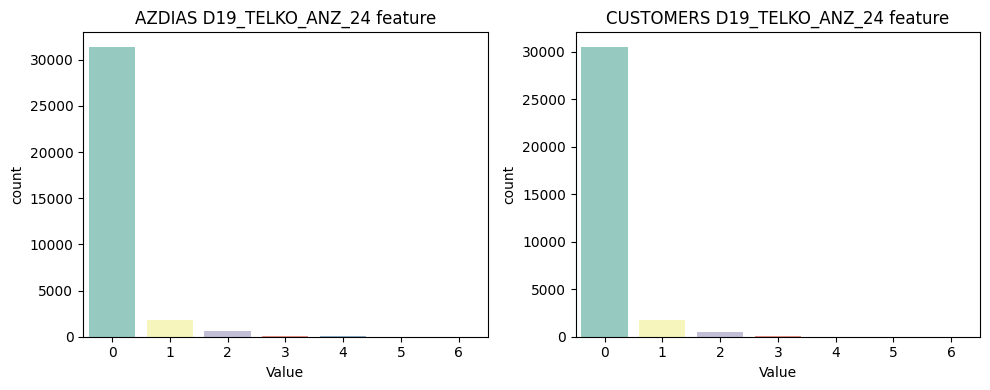

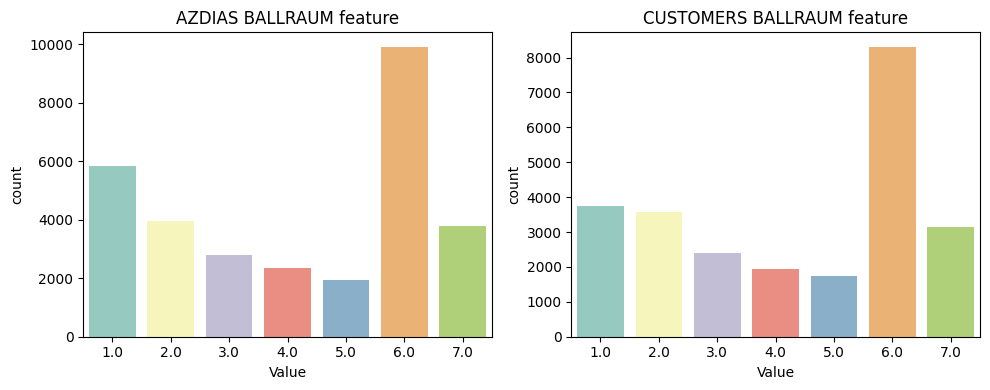

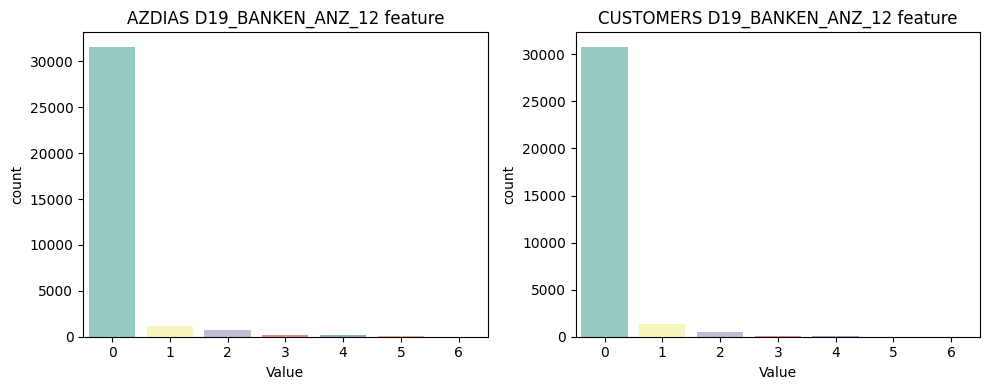

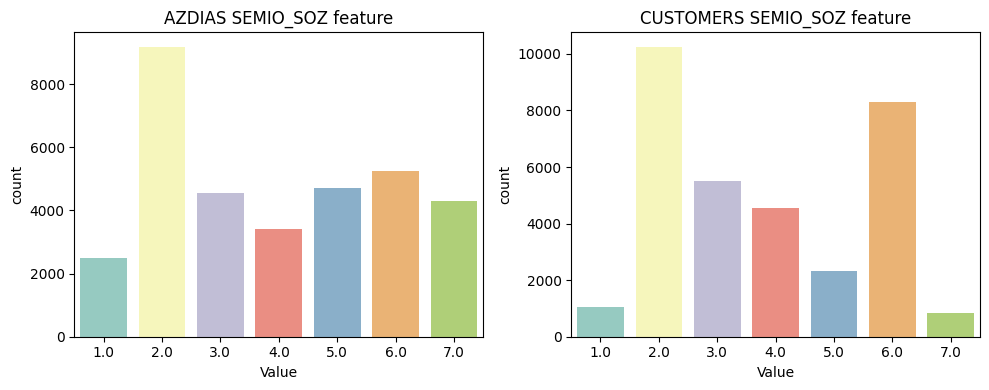

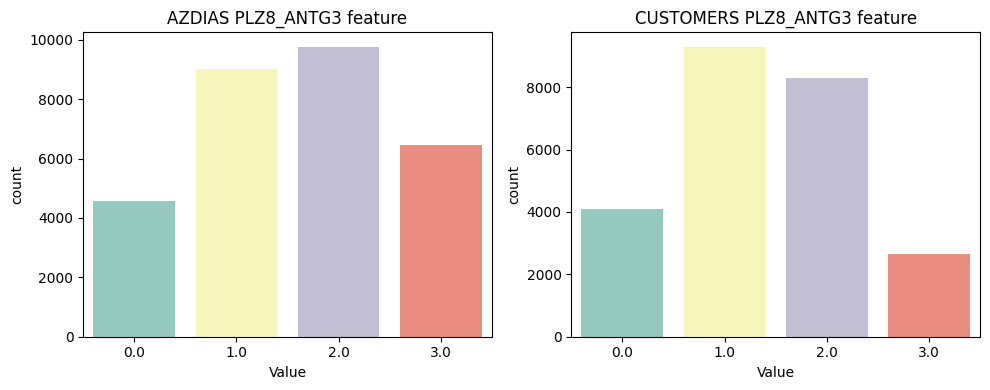

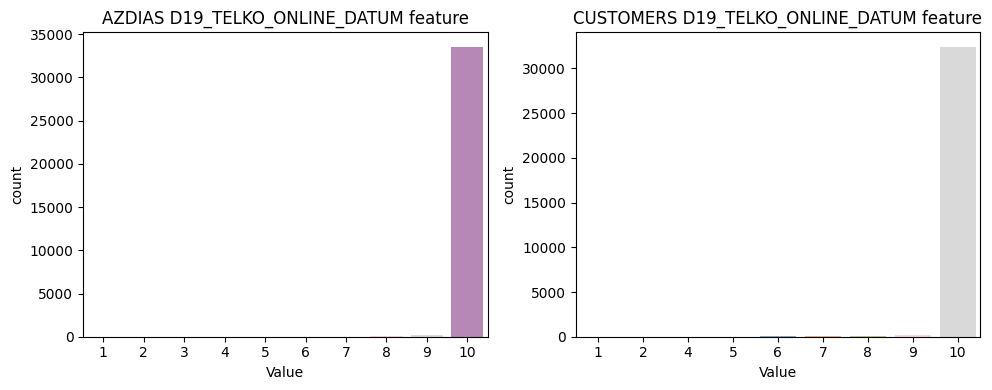

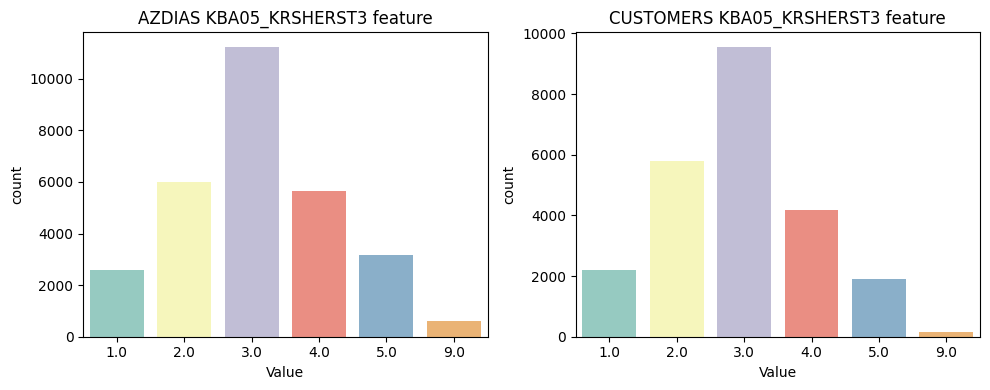

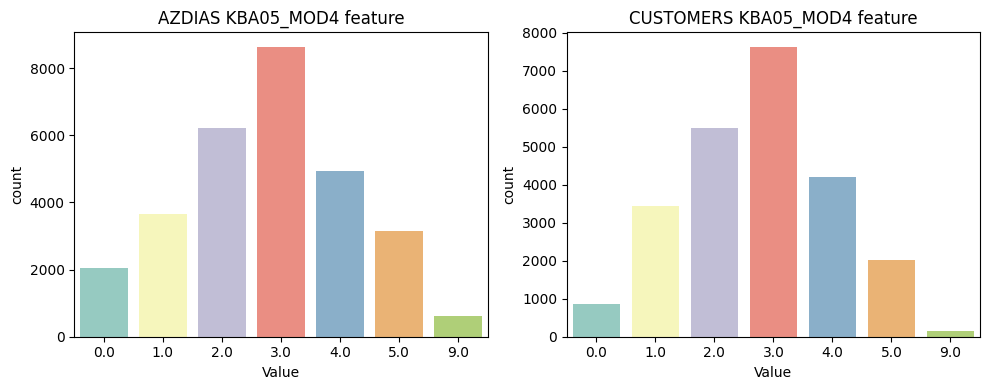

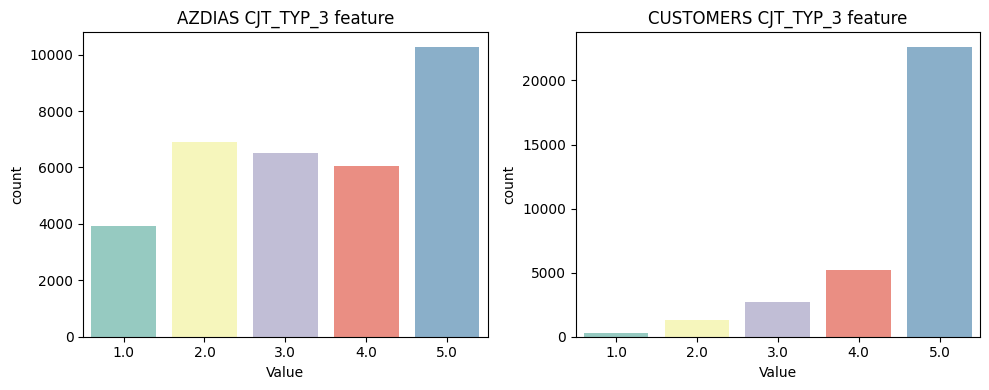

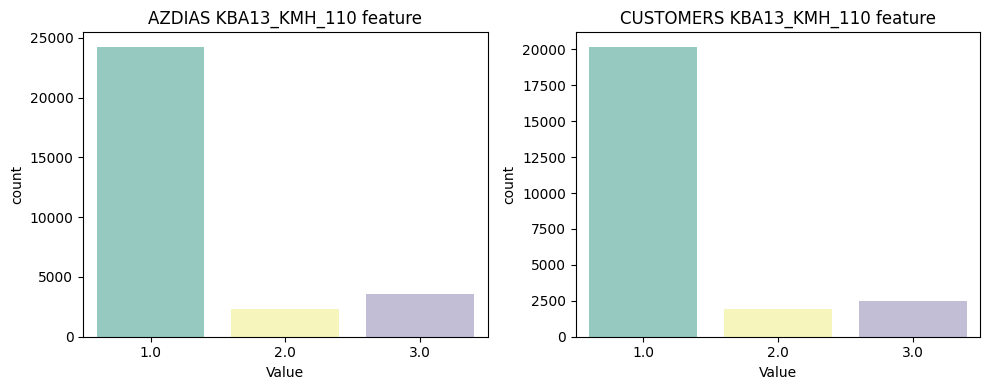

In [28]:
for i in random.sample(range(0,len(azdias.columns)-1),10):
    azdias_customers_plot(azdias.columns[i])

- From the random distribution map, the two data sets are distributed and similar

### 1.Deal with the numerical features

In [29]:
# define a drop features list
drop_features=set()

In [30]:
# in numerical_attribute: 
# {'MIN_GEBAEUDEJAHR', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_TITEL', 'ANZ_PERSONEN', 'GEBURTSJAHR', 'ANZ_HH_TITEL', 'KBA13_ANZAHL_PKW'}
my_azdias[list(numerical_attribute)].head()

,MIN_GEBAEUDEJAHR,ANZ_HH_TITEL,KBA13_ANZAHL_PKW,GEBURTSJAHR,ANZ_TITEL,ANZ_PERSONEN,ANZ_HAUSHALTE_AKTIV
0,NaN,NaN,NaN,0,NaN,NaN,NaN
1,1992.0,0.0,963.0,1996,0.0,2.0,11.0
2,1992.0,0.0,712.0,1979,0.0,1.0,10.0
3,1997.0,0.0,596.0,1957,0.0,0.0,1.0
4,1992.0,0.0,435.0,1963,0.0,4.0,3.0


- 'MIN_GEBAEUDEJAHR' will be replaced by age.
- 'GEBURTSJAHR' will be replaced by age.

In [31]:
numerical_attribute

{'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'GEBURTSJAHR',
 'KBA13_ANZAHL_PKW',
 'MIN_GEBAEUDEJAHR'}

In [32]:
DIAS_attributes['Attribute'].value_counts()

Attribute
CAMEO_DEU_2015           44
LP_LEBENSPHASE_FEIN      40
CAMEO_DEUINTL_2015       26
ALTER_HH                 22
PRAEGENDE_JUGENDJAHRE    16
                         ..
ANZ_PERSONEN              1
MIN_GEBAEUDEJAHR          1
ANZ_HH_TITEL              1
ANZ_HAUSHALTE_AKTIV       1
KBA13_ANZAHL_PKW          1
Name: count, Length: 314, dtype: int64

- I think the numeric features have only 1 values meaning.

In [33]:
attribute_value_number=[]
for i in my_azdias.columns:
    attribute_value_number.append((len(my_azdias[i].value_counts()),i))

In [34]:
print(sorted(attribute_value_number))

[(2, 'ANREDE_KZ'), (2, 'DSL_FLAG'), (2, 'GREEN_AVANTGARDE'), (2, 'HH_DELTA_FLAG'), (2, 'KBA05_SEG6'), (2, 'KONSUMZELLE'), (2, 'OST_WEST_KZ'), (2, 'SOHO_KZ'), (2, 'UNGLEICHENN_FLAG'), (2, 'VERS_TYP'), (3, 'ANZ_TITEL'), (3, 'D19_TELKO_ONLINE_QUOTE_12'), (3, 'HEALTH_TYP'), (3, 'KBA05_ANTG4'), (3, 'KBA05_KRSKLEIN'), (3, 'KBA05_KRSOBER'), (3, 'KBA05_KRSVAN'), (3, 'KBA05_KRSZUL'), (3, 'KBA05_MAXVORB'), (3, 'KBA13_ANTG4'), (3, 'KBA13_KMH_110'), (3, 'KBA13_KMH_251'), (3, 'KBA13_KW_30'), (3, 'NATIONALITAET_KZ'), (3, 'PLZ8_ANTG4'), (3, 'STRUKTURTYP'), (4, 'AGER_TYP'), (4, 'D19_VERSI_ONLINE_QUOTE_12'), (4, 'KBA05_ANHANG'), (4, 'KBA05_ANTG3'), (4, 'KBA05_MAXBJ'), (4, 'KBA05_MAXSEG'), (4, 'KBA05_MOD8'), (4, 'KBA05_MOTOR'), (4, 'KBA05_MOTRAD'), (4, 'KBA05_SEG1'), (4, 'KBA05_SEG7'), (4, 'KBA05_SEG8'), (4, 'KBA05_SEG9'), (4, 'KBA13_ANTG3'), (4, 'KBA13_KRSSEG_KLEIN'), (4, 'KBA13_KRSSEG_OBER'), (4, 'KBA13_KRSSEG_VAN'), (4, 'KBA13_KRSZUL_NEU'), (4, 'KBA13_MOTOR'), (4, 'KKK'), (4, 'PLZ8_ANTG3'), (4, 'SHOP

- numerical feature might have more value,so I will check the value count bigger than 30

In [35]:
# find out the value count bigger than 30
[x for x in attribute_value_number if x[0]>30]

[(33872, 'LNR'),
 (158, 'ANZ_HAUSHALTE_AKTIV'),
 (149, 'ANZ_STATISTISCHE_HAUSHALTE'),
 (45, 'CAMEO_DEU_2015'),
 (43, 'CAMEO_INTL_2015'),
 (35, 'D19_LETZTER_KAUF_BRANCHE'),
 (1724, 'EINGEFUEGT_AM'),
 (32, 'EINGEZOGENAM_HH_JAHR'),
 (56, 'EXTSEL992'),
 (111, 'GEBURTSJAHR'),
 (1232, 'KBA13_ANZAHL_PKW'),
 (41, 'LP_LEBENSPHASE_FEIN'),
 (32, 'MIN_GEBAEUDEJAHR'),
 (46, 'VERDICHTUNGSRAUM')]

In [36]:
# find more numberical attribute 
set([x[1] for x in attribute_value_number if x[0]>30])-numerical_attribute-drop_features-set(['LNR'])

{'ANZ_STATISTISCHE_HAUSHALTE',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'EXTSEL992',
 'LP_LEBENSPHASE_FEIN',
 'VERDICHTUNGSRAUM'}

- LNR will be the index,
- EINGEFUEGT_AM,D19_LETZTER_KAUF_BRANCHE,EINGEZOGENAM_HH_JAHR I don't know what is it.

In [37]:
drop_features=drop_features|set(['EINGEFUEGT_AM','D19_LETZTER_KAUF_BRANCHE','EINGEZOGENAM_HH_JAHR'])

In [38]:
drop_features

{'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR'}

In [39]:
my_azdias['ANZ_STATISTISCHE_HAUSHALTE'].value_counts()

ANZ_STATISTISCHE_HAUSHALTE
1.0      8009
2.0      4660
3.0      2357
4.0      1679
5.0      1593
         ... 
146.0       1
127.0       1
93.0        1
140.0       1
155.0       1
Name: count, Length: 149, dtype: int64

- It has many values so I think it's a numerical feature. 

In [40]:
numerical_attribute.add('ANZ_STATISTISCHE_HAUSHALTE')

In [41]:
my_azdias['EXTSEL992'].value_counts()

EXTSEL992
56.0    747
31.0    564
38.0    540
27.0    524
23.0    511
36.0    465
35.0    439
55.0    376
34.0    320
50.0    255
53.0    230
37.0    209
21.0    207
6.0     191
41.0    185
19.0    172
54.0    169
33.0    168
39.0    163
29.0    162
20.0    158
18.0    157
25.0    146
14.0    128
48.0    127
26.0    118
17.0    118
46.0    114
40.0    113
32.0    110
3.0     101
22.0     98
43.0     97
15.0     95
24.0     90
2.0      82
47.0     62
45.0     62
4.0      59
30.0     58
1.0      55
13.0     54
5.0      50
16.0     48
52.0     48
42.0     42
12.0     37
9.0      35
10.0     34
51.0     33
11.0     30
8.0      29
7.0      19
44.0     14
49.0     10
28.0      7
Name: count, dtype: int64

- It has many values so I think it's a numerical feature. 

In [42]:
numerical_attribute.add('EXTSEL992')

In [43]:
my_azdias['VERDICHTUNGSRAUM'].value_counts()

VERDICHTUNGSRAUM
0.0     14091
1.0      4265
2.0      1771
3.0      1194
4.0      1043
5.0       909
6.0       841
7.0       490
8.0       482
10.0      420
9.0       367
11.0      331
12.0      330
14.0      324
13.0      321
15.0      292
16.0      244
17.0      209
18.0      195
25.0      133
21.0      132
24.0      131
23.0      130
19.0      128
20.0      128
29.0      118
22.0      115
32.0      110
26.0      100
33.0       98
28.0       94
30.0       92
27.0       86
31.0       83
35.0       76
39.0       73
36.0       68
34.0       67
44.0       64
40.0       56
45.0       56
42.0       52
41.0       49
37.0       48
38.0       40
43.0       37
Name: count, dtype: int64

- It has many values so I think it's a numerical feature. 

In [44]:
numerical_attribute.add('VERDICHTUNGSRAUM')

In [45]:
# find out the features that have more than 30 values
set([x[1] for x in attribute_value_number if x[0]>30])-numerical_attribute-drop_features-set(['LNR'])

{'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN'}

In [46]:
print(my_azdias['CAMEO_DEU_2015'].value_counts(),my_azdias['CAMEO_INTL_2015'].value_counts(),my_azdias['LP_LEBENSPHASE_FEIN'].value_counts())

CAMEO_DEU_2015
6B    2234
8A    2017
4C    1824
3C    1345
7A    1324
2D    1317
8B    1282
4A    1249
3D    1210
8C    1203
9D    1166
9B    1028
9C     983
7B     951
9A     820
2C     728
8D     696
6E     629
6C     580
2B     542
5D     540
2A     510
5A     481
1D     456
1A     425
5B     386
7C     386
3A     378
4D     358
5C     353
4B     327
9E     271
3B     268
6A     262
7D     225
6D     224
6F     220
4E     218
1E     184
5F     175
7E     171
1C     167
1B     158
5E     116
XX      10
Name: count, dtype: int64 CAMEO_INTL_2015
51.0    2810
51      2384
41.0    1959
24.0    1934
41      1598
24      1593
14.0    1297
43.0    1223
14      1073
43      1011
54.0     989
54       825
25.0     802
22.0     686
25       626
22       563
45.0     556
55.0     530
23.0     505
13.0     502
23       468
13       465
45       464
52.0     453
55       437
31.0     397
15.0     376
52       367
34.0     349
31       346
34       307
44.0     303
44       277
12.0     269
15    

- It has many values so I think it's a numerical feature. 

In [47]:
numerical_attribute.add('LP_LEBENSPHASE_FEIN')

In [48]:
print(numerical_attribute)

{'MIN_GEBAEUDEJAHR', 'ANZ_HH_TITEL', 'VERDICHTUNGSRAUM', 'KBA13_ANZAHL_PKW', 'GEBURTSJAHR', 'LP_LEBENSPHASE_FEIN', 'EXTSEL992', 'ANZ_TITEL', 'ANZ_PERSONEN', 'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_HAUSHALTE_AKTIV'}


- That's all,I accept the result of numerical features.

### 2.Deal with the categories features

In [49]:
# find out the categories features
categories_attribute=set(my_azdias.columns)-numerical_attribute-drop_features-set(['LNR'])
my_azdias_categories=my_azdias[list(categories_attribute)]

In [50]:
# See which data types are in the category properties
my_azdias_categories.columns.to_series().groupby(my_azdias_categories.dtypes).groups

{int64: ['D19_VERSAND_DATUM', 'D19_TELKO_ANZ_24', 'D19_DROGERIEARTIKEL', 'D19_GESAMT_OFFLINE_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSAND_REST', 'D19_VERSI_ANZ_24', 'D19_WEIN_FEINKOST', 'D19_SCHUHE', 'D19_KINDERARTIKEL', 'D19_BEKLEIDUNG_GEH', 'D19_VERSICHERUNGEN', 'D19_VERSAND_OFFLINE_DATUM', 'D19_SAMMELARTIKEL', 'D19_BANKEN_LOKAL', 'D19_KONSUMTYP_MAX', 'D19_TELKO_ONLINE_DATUM', 'D19_KOSMETIK', 'D19_NAHRUNGSERGAENZUNG', 'D19_TELKO_REST', 'D19_BANKEN_GROSS', 'D19_VERSI_DATUM', 'D19_GESAMT_DATUM', 'GREEN_AVANTGARDE', 'D19_VERSI_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_BANKEN_ONLINE_DATUM', 'D19_GARTEN', 'D19_BEKLEIDUNG_REST', 'D19_RATGEBER', 'D19_BANKEN_DIREKT', 'D19_TELKO_ANZ_12', 'D19_VERSAND_ANZ_12', 'FINANZ_VORSORGER', 'D19_BANKEN_OFFLINE_DATUM', 'KOMBIALTER', 'FINANZ_SPARER', 'D19_TELKO_OFFLINE_DATUM', 'D19_TECHNIK', 'D19_FREIZEIT', 'D19_TELKO_MOBILE', 'D19_BILDUNG', 'FINANZ_ANLEGER', 'D19_REISEN', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'FINANZ_MINIMALIST', 'D19_TELKO

In [51]:
# focus the object data type features ['CAMEO_DEUG_2015', 'OST_WEST_KZ', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015']
# first CAMEO_DEUG_2015,CAMEO_INTL_2015,CAMEO_DEU_2015
CAMEO_list=[]
for l in azdias.columns.tolist():
    if 'CAMEO' in l:
        CAMEO_list.append(l)
print(CAMEO_list)

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015']


In [52]:
my_azdias_categories[CAMEO_list].head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015
0,NaN,NaN,NaN
1,8A,8.0,51.0
2,4C,4.0,24.0
3,2A,2.0,12.0
4,6B,6.0,43.0


In [53]:
print(my_azdias_categories['CAMEO_DEUG_2015'].value_counts())
print(my_azdias_categories['CAMEO_DEU_2015'].value_counts())
print(my_azdias_categories['CAMEO_INTL_2015'].value_counts())

CAMEO_DEUG_2015
8.0    2806
8      2392
9.0    2362
6.0    2261
4.0    2204
9      1906
6      1888
4      1772
3.0    1723
2.0    1680
7.0    1662
3      1478
2      1417
7      1395
5.0    1135
5       916
1.0     764
1       626
X        10
Name: count, dtype: int64
CAMEO_DEU_2015
6B    2234
8A    2017
4C    1824
3C    1345
7A    1324
2D    1317
8B    1282
4A    1249
3D    1210
8C    1203
9D    1166
9B    1028
9C     983
7B     951
9A     820
2C     728
8D     696
6E     629
6C     580
2B     542
5D     540
2A     510
5A     481
1D     456
1A     425
5B     386
7C     386
3A     378
4D     358
5C     353
4B     327
9E     271
3B     268
6A     262
7D     225
6D     224
6F     220
4E     218
1E     184
5F     175
7E     171
1C     167
1B     158
5E     116
XX      10
Name: count, dtype: int64
CAMEO_INTL_2015
51.0    2810
51      2384
41.0    1959
24.0    1934
41      1598
24      1593
14.0    1297
43.0    1223
14      1073
43      1011
54.0     989
54       825
25.0     802
22.0     

In [54]:
my_azdias_categories['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)
my_azdias_categories['CAMEO_INTL_2015'].replace('XX',np.nan,inplace=True)
my_azdias_categories['CAMEO_DEUG_2015']=my_azdias_categories['CAMEO_DEUG_2015'].astype('float')
my_azdias_categories['CAMEO_INTL_2015']=my_azdias_categories['CAMEO_INTL_2015'].astype('float')

C:\Users\AVELL\AppData\Local\Temp\ipykernel_9596\2181937908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_azdias_categories['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)
C:\Users\AVELL\AppData\Local\Temp\ipykernel_9596\2181937908.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_azdias_categories['CAMEO_INTL_2015'].replace('XX',np.nan,inplace=True)
C:\Users\AVELL\AppData\Local\Temp\ipykernel_9596\2181937908.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [55]:
my_azdias_categories[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].corr()

,CAMEO_DEUG_2015,CAMEO_INTL_2015
CAMEO_DEUG_2015,1.000000,0.954862
CAMEO_INTL_2015,0.954862,1.000000


- according the attribute description 'CAMEO_DEU_2015' 'CAMEO_INTL_2015' include more detail than CAMEO_DEUG_2015.The correlation between  'CAMEO_DEUG_2015'and 'CAMEO_INTL_2015' is high.

In [56]:
# I will drop CAMEO_DEU_2015 and CAMEO_INTL_2015 
drop_features.add('CAMEO_DEU_2015')
drop_features.add('CAMEO_INTL_2015')

In [57]:
print(drop_features)

{'CAMEO_INTL_2015', 'EINGEZOGENAM_HH_JAHR', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'CAMEO_DEU_2015'}


In [58]:
# I will check the value count is 2 as binary_attribute
binary_attribute=set([x[1] for x in attribute_value_number if x[0]==2])

In [59]:
print(binary_attribute)

{'VERS_TYP', 'HH_DELTA_FLAG', 'GREEN_AVANTGARDE', 'ANREDE_KZ', 'KONSUMZELLE', 'SOHO_KZ', 'OST_WEST_KZ', 'DSL_FLAG', 'UNGLEICHENN_FLAG', 'KBA05_SEG6'}


In [60]:
multiple_categories_attribute=set(my_azdias.columns)-numerical_attribute-drop_features-set(['LNR'])-binary_attribute

In [61]:
print(multiple_categories_attribute)

{'KBA13_MERCEDES', 'D19_VERSAND_DATUM', 'CJT_TYP_5', 'D19_TELKO_ANZ_24', 'KBA13_KMH_0_140', 'SEMIO_MAT', 'AGER_TYP', 'KBA05_MOTRAD', 'WOHNDAUER_2008', 'AKT_DAT_KL', 'D19_DROGERIEARTIKEL', 'D19_GESAMT_OFFLINE_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'KBA13_HALTER_45', 'KBA13_KRSAQUOT', 'ARBEIT', 'CJT_GESAMTTYP', 'KBA13_SITZE_5', 'D19_VERSI_ONLINE_QUOTE_12', 'KBA05_MAXAH', 'ORTSGR_KLS9', 'KBA13_KW_121', 'KBA05_KRSHERST2', 'KBA13_KRSHERST_FORD_OPEL', 'ZABEOTYP', 'KBA13_CCM_2500', 'KBA13_KMH_251', 'VHN', 'D19_VERSAND_REST', 'D19_VERSI_ANZ_24', 'KBA13_CCM_1600', 'KBA13_VORB_3', 'KBA13_BJ_2006', 'KBA13_MOTOR', 'D19_GESAMT_ONLINE_QUOTE_12', 'SHOPPER_TYP', 'KBA13_PEUGEOT', 'D19_WEIN_FEINKOST', 'D19_SCHUHE', 'D19_KINDERARTIKEL', 'KBA13_KW_110', 'VK_ZG11', 'KBA05_KRSZUL', 'RT_SCHNAEPPCHEN', 'D19_BEKLEIDUNG_GEH', 'KBA13_HALTER_40', 'KBA13_HERST_SONST', 'D19_VERSICHERUNGEN', 'D19_VERSAND_OFFLINE_DATUM', 'D19_SAMMELARTIKEL', 'KBA13_KMH_211', 'LP_FAMILIE_FEIN', 'PLZ8_ANTG2', 'CAM

In [62]:
my_azdias_categories_corr = my_azdias_categories[list(multiple_categories_attribute)].corr()

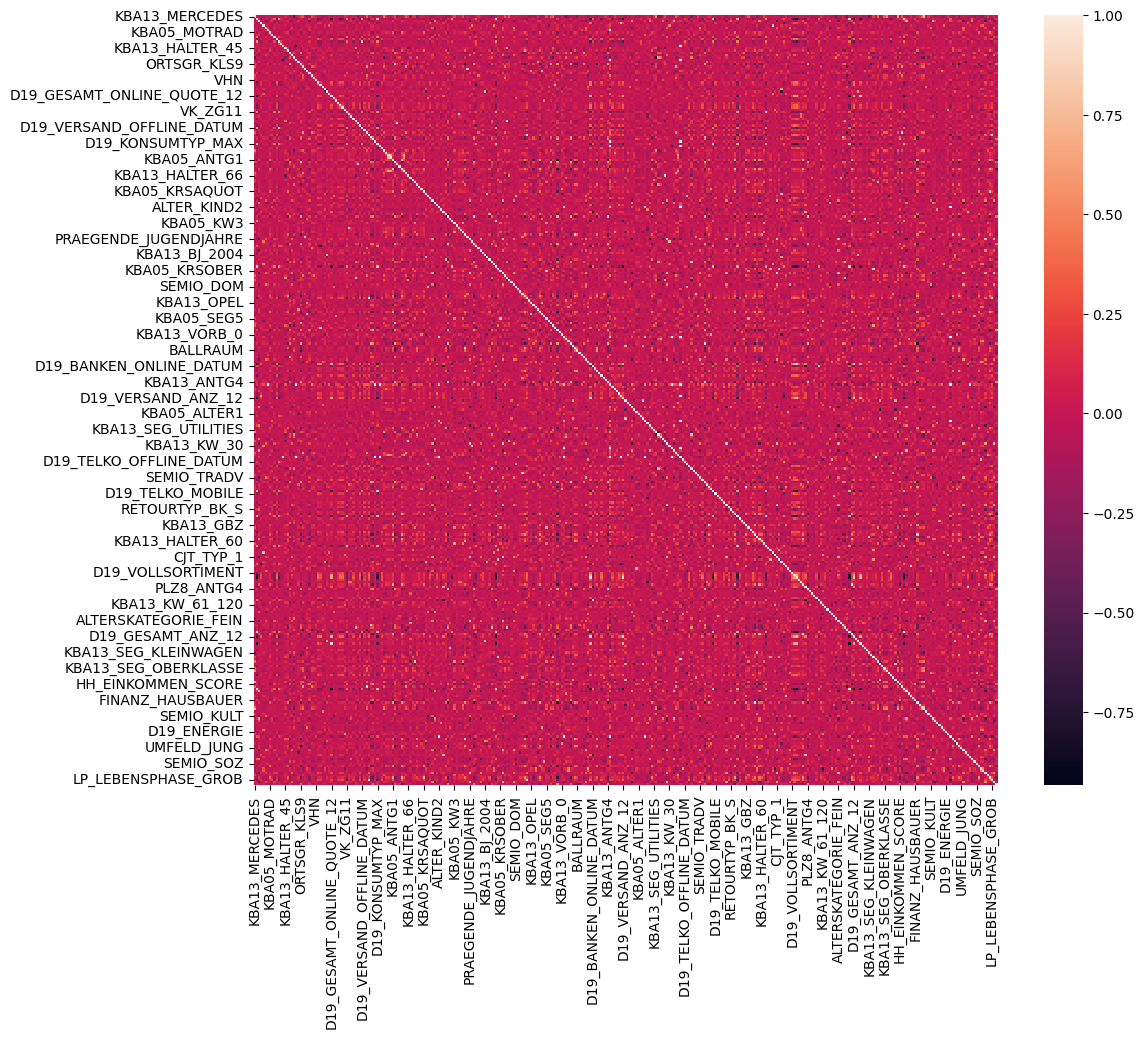

In [63]:
plt.figure(figsize=(12,10))
sns.heatmap(my_azdias_categories_corr)  
plt.show()

In [64]:
my_azdias_categories_corr_=my_azdias_categories_corr.replace(1,0)

In [65]:
# find out relevance features greater than 90%
categories_corr_list=[]
for i, row in my_azdias_categories_corr_.iterrows():
    corr_index=row[row.values>0.90].index
    if len(corr_index) !=0:
        corr_list=set(corr_index.tolist())
        corr_list.add(i)
        categories_corr_list.append(corr_list)

In [66]:
categories_corr_list

[{'D19_GESAMT_ONLINE_DATUM', 'D19_VERSAND_DATUM', 'D19_VERSAND_ONLINE_DATUM'},
 {'D19_GESAMT_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12'},
 {'KBA13_KMH_211', 'KBA13_KMH_250'},
 {'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB'},
 {'KBA13_ALTERHALTER_61', 'KBA13_HALTER_66'},
 {'KBA13_BAUMAX', 'PLZ8_BAUMAX'},
 {'KBA13_BAUMAX', 'PLZ8_BAUMAX'},
 {'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB'},
 {'KBA13_ANTG3', 'PLZ8_ANTG3'},
 {'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_24'},
 {'D19_GESAMT_ANZ_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24'},
 {'KBA13_ALTERHALTER_61', 'KBA13_HALTER_66'},
 {'KBA13_ANTG3', 'PLZ8_ANTG3'},
 {'KBA13_GBZ', 'PLZ8_GBZ'},
 {'KBA13_GBZ', 'PLZ8_GBZ'},
 {'KBA13_ANTG1', 'PLZ8_ANTG1'},
 {'KBA13_HHZ', 'PLZ8_HHZ'},
 {'D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24'},
 {'LP_STATUS_FEIN', 'LP_STATUS_GROB'},
 {'D19_GESAMT_ONLINE_DATUM', 'D19_VERSAND_DATUM', 'D19_VERSAND_ONLINE_DATUM'},
 {'LP_STATUS_FEIN', 'LP_STATUS_

In [67]:
# remove duplicate
categories_corr_list_ = []
for i in categories_corr_list:
    if len(categories_corr_list_)>0:
        add_flag=1
        for j in categories_corr_list_:
            if len(i-j)==0:
                add_flag=0
        if add_flag==1:
            categories_corr_list_.append(i)
    else:
        categories_corr_list_.append(i)
print(categories_corr_list_) 

[{'D19_VERSAND_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM'}, {'D19_GESAMT_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12'}, {'KBA13_KMH_211', 'KBA13_KMH_250'}, {'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_GROB', 'LP_FAMILIE_FEIN'}, {'KBA13_ALTERHALTER_61', 'KBA13_HALTER_66'}, {'KBA13_BAUMAX', 'PLZ8_BAUMAX'}, {'KBA13_ANTG3', 'PLZ8_ANTG3'}, {'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_24'}, {'D19_GESAMT_ANZ_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24'}, {'PLZ8_GBZ', 'KBA13_GBZ'}, {'KBA13_ANTG1', 'PLZ8_ANTG1'}, {'KBA13_HHZ', 'PLZ8_HHZ'}, {'D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24'}, {'LP_STATUS_FEIN', 'LP_STATUS_GROB'}, {'D19_GESAMT_ANZ_24', 'D19_GESAMT_ANZ_12', 'D19_VERSAND_ANZ_12'}]


In [68]:
# drop some featrues according the categories_corr_list_ and DIAS Attributes - Values 2017.xlsx 
drop_features.add('KBA13_ANTG1')
drop_features.add('LP_FAMILIE_GROB')
drop_features.add('LP_FAMILIE_FEIN')
drop_features.add('KBA13_KMH_250')
drop_features.add('KBA13_HHZ')
drop_features.add('D19_GESAMT_ONLINE_QUOTE_12')
drop_features.add('KBA13_HALTER_66')
drop_features.add('LP_STATUS_GROB')
drop_features.add('D19_GESAMT_ANZ_24')
drop_features.add('D19_VERSAND_ANZ_24')
drop_features.add('D19_VERSAND_ANZ_12')
drop_features.add('KBA13_GBZ')
drop_features.add('KBA13_BAUMAX')
drop_features.add('KBA13_ANTG3')
drop_features.add('D19_GESAMT_ONLINE_DATUM')
drop_features.add('D19_VERSAND_ONLINE_DATUM')

- My standard is to exclude the absence of attribute descriptions, and then choose more and more value types.

In [69]:
multiple_categories_attribute=multiple_categories_attribute-drop_features

In [70]:
print(binary_attribute)

{'VERS_TYP', 'HH_DELTA_FLAG', 'GREEN_AVANTGARDE', 'ANREDE_KZ', 'KONSUMZELLE', 'SOHO_KZ', 'OST_WEST_KZ', 'DSL_FLAG', 'UNGLEICHENN_FLAG', 'KBA05_SEG6'}


In [71]:
print(multiple_categories_attribute)

{'KBA13_MERCEDES', 'D19_VERSAND_DATUM', 'CJT_TYP_5', 'D19_TELKO_ANZ_24', 'KBA13_KMH_0_140', 'SEMIO_MAT', 'AGER_TYP', 'KBA05_MOTRAD', 'WOHNDAUER_2008', 'AKT_DAT_KL', 'D19_DROGERIEARTIKEL', 'D19_GESAMT_OFFLINE_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'KBA13_HALTER_45', 'KBA13_KRSAQUOT', 'ARBEIT', 'CJT_GESAMTTYP', 'KBA13_SITZE_5', 'D19_VERSI_ONLINE_QUOTE_12', 'KBA05_MAXAH', 'ORTSGR_KLS9', 'KBA13_KW_121', 'KBA05_KRSHERST2', 'KBA13_KRSHERST_FORD_OPEL', 'ZABEOTYP', 'KBA13_CCM_2500', 'KBA13_KMH_251', 'VHN', 'D19_VERSAND_REST', 'D19_VERSI_ANZ_24', 'KBA13_CCM_1600', 'KBA13_VORB_3', 'KBA13_BJ_2006', 'KBA13_MOTOR', 'SHOPPER_TYP', 'KBA13_PEUGEOT', 'D19_WEIN_FEINKOST', 'D19_SCHUHE', 'D19_KINDERARTIKEL', 'KBA13_KW_110', 'VK_ZG11', 'KBA05_KRSZUL', 'RT_SCHNAEPPCHEN', 'D19_BEKLEIDUNG_GEH', 'KBA13_HALTER_40', 'KBA13_HERST_SONST', 'D19_VERSICHERUNGEN', 'D19_VERSAND_OFFLINE_DATUM', 'D19_SAMMELARTIKEL', 'KBA13_KMH_211', 'PLZ8_ANTG2', 'CAMEO_DEUG_2015', 'D19_BANKEN_LOKAL', 'D19_KONSUMTYP

### 3.process the missing values and deal with some features

In [72]:
# deal with columns
azdias_col_null=(my_azdias.isnull().sum()/len(my_azdias)).sort_values(ascending=False)
customers_col_null=(my_customers.isnull().sum()/len(my_customers)).sort_values(ascending=False)

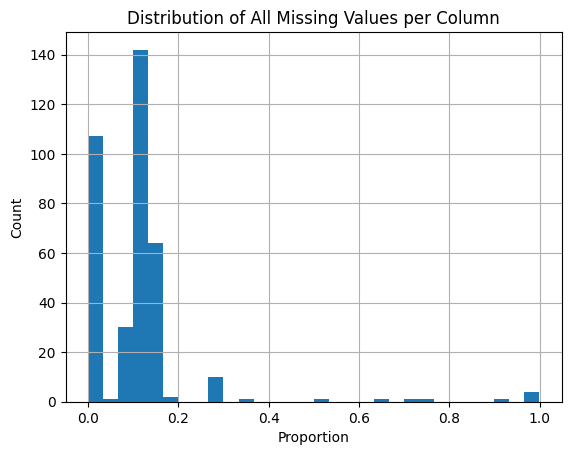

In [73]:
azdias_col_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Column');

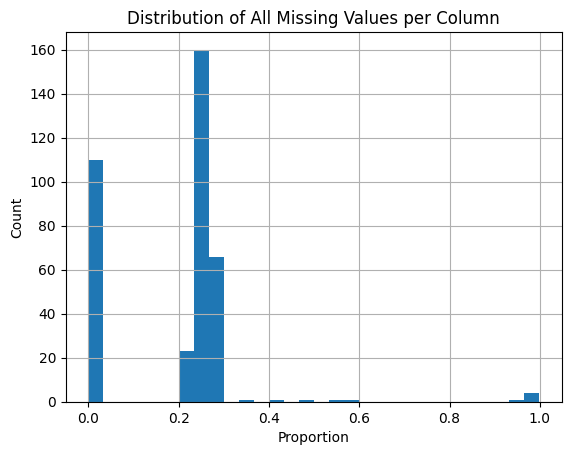

In [74]:
customers_col_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Column');

In [75]:
#remove the features that has over 30% missing rate
remove_features=set(azdias_col_null[azdias_col_null>0.3].index)|set(customers_col_null[customers_col_null>0.3].index)
print(remove_features)
# azdias.drop(labels=remove_features,axis=1,inplace=True)
# customers.drop(labels=remove_features,axis=1,inplace=True)
# print(azdias.shape,customers.shape)
drop_features=drop_features|remove_features
print(drop_features)

{'AGER_TYP', 'ALTER_KIND2', 'KK_KUNDENTYP', 'ALTER_HH', 'ALTER_KIND1', 'TITEL_KZ', 'KBA05_BAUMAX', 'EXTSEL992', 'ALTER_KIND4', 'ALTER_KIND3'}
{'KBA13_BAUMAX', 'KBA13_ANTG1', 'ALTER_KIND4', 'EINGEZOGENAM_HH_JAHR', 'D19_LETZTER_KAUF_BRANCHE', 'AGER_TYP', 'ALTER_KIND2', 'D19_VERSAND_ANZ_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'EINGEFUEGT_AM', 'KK_KUNDENTYP', 'ALTER_HH', 'KBA13_HALTER_66', 'LP_FAMILIE_FEIN', 'KBA13_KMH_250', 'D19_GESAMT_ONLINE_DATUM', 'CAMEO_INTL_2015', 'D19_GESAMT_ANZ_24', 'ALTER_KIND1', 'D19_VERSAND_ONLINE_DATUM', 'TITEL_KZ', 'LP_STATUS_GROB', 'D19_VERSAND_ANZ_24', 'KBA05_BAUMAX', 'LP_FAMILIE_GROB', 'KBA13_HHZ', 'EXTSEL992', 'KBA13_ANTG3', 'KBA13_GBZ', 'CAMEO_DEU_2015', 'ALTER_KIND3'}


In [76]:
# redefine the categories_attribute and the numerical_attribute
numerical_attribute=numerical_attribute-drop_features
multiple_categories_attribute=multiple_categories_attribute-drop_features
binary_attribute=binary_attribute-drop_features

In [77]:
drop_features

{'AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_ONLINE_DATUM',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KBA13_ANTG1',
 'KBA13_ANTG3',
 'KBA13_BAUMAX',
 'KBA13_GBZ',
 'KBA13_HALTER_66',
 'KBA13_HHZ',
 'KBA13_KMH_250',
 'KK_KUNDENTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_GROB',
 'TITEL_KZ'}

In [78]:
my_azdias.drop(labels=drop_features,axis=1,inplace=True)
my_customers.drop(labels=drop_features,axis=1,inplace=True)

In [79]:
# deal with rows
azdias_row_null=(my_azdias.isnull().mean(axis=1)).sort_values(ascending=False)
customers_row_null=(my_customers.isnull().mean(axis=1)).sort_values(ascending=False)

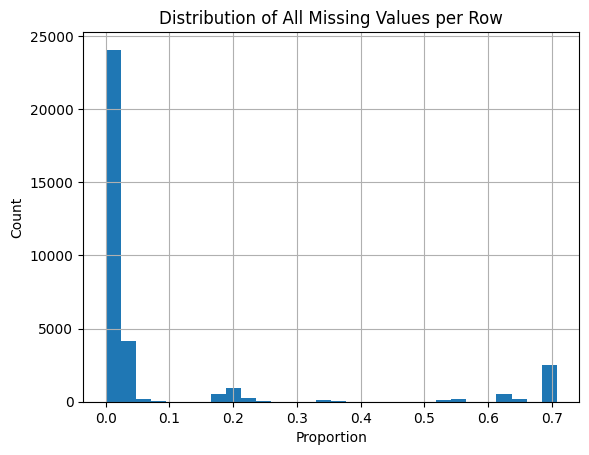

In [80]:
azdias_row_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Row');

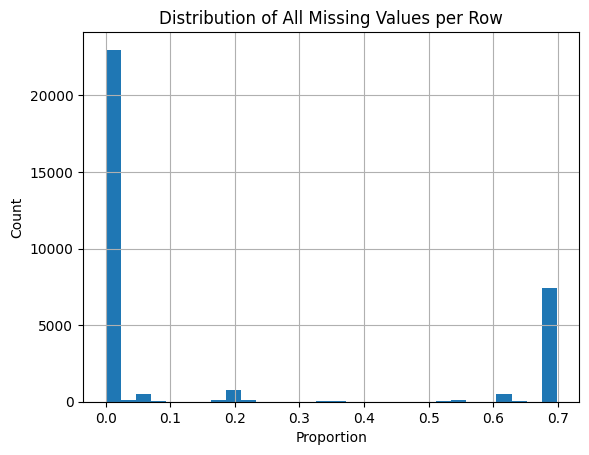

In [81]:
customers_row_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Row');

In [82]:
print(my_azdias.shape,my_customers.shape)

(33872, 335) (32780, 338)


In [83]:
#remove the row that has over 10% missing rate
azdias_remove_row=azdias_row_null[azdias_row_null>0.1].index
customers_remove_row=customers_row_null[customers_row_null>0.1].index

my_azdias.drop(index=azdias_remove_row,axis=0,inplace=True)
my_customers.drop(index=customers_remove_row,axis=0,inplace=True)

In [84]:
print(my_azdias.shape,my_customers.shape)

(28414, 335) (23575, 338)


In [85]:
print(my_azdias.isnull().mean().mean())
print(my_customers.isnull().mean().mean())

0.007330735636941638
0.0023760251494977


In [86]:
# set index
my_azdias.set_index('LNR',inplace=True)
my_customers.set_index('LNR',inplace=True)

In [87]:
# dorp 3 attribute that only in my_customers dataset  
my_customers.drop(labels=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'],axis=1,inplace=True)

### There are three types of data processing: numerical features, binary features and multiple categories features

In [88]:
# deal with the numerical features
# deal with the 'MIN_GEBAEUDEJAHR' , 'GEBURTSJAHR'
my_azdias['MIN_GEBAEUDEJAHR']=2017-my_azdias['MIN_GEBAEUDEJAHR']
my_azdias['GEBURTSJAHR']=2017-my_azdias['GEBURTSJAHR']

my_customers['MIN_GEBAEUDEJAHR']=2017-my_customers['MIN_GEBAEUDEJAHR']
my_customers['GEBURTSJAHR']=2017-my_customers['GEBURTSJAHR']

In [89]:
# fill the missing data in numerical_attribute
for l in numerical_attribute:
    my_azdias[l]=my_azdias[l].fillna(value=round(my_azdias[l].mean()))
    my_customers[l]=my_customers[l].fillna(value=round(my_customers[l].mean()))

In [90]:
len(my_azdias[list(numerical_attribute)].isnull().any()[my_azdias[list(numerical_attribute)].isnull().any()==True].index)

0

In [91]:
len(my_customers[list(numerical_attribute)].isnull().any()[my_customers[list(numerical_attribute)].isnull().any()==True].index)

0

- numerical features complete

In [92]:
# deal with the multiple_categories_attribute
my_azdias[list(multiple_categories_attribute)].columns.to_series(multiple_categories_attribute).groupby(my_azdias.dtypes).groups

{int64: ['D19_VERSAND_DATUM', 'D19_TELKO_ANZ_24', 'D19_DROGERIEARTIKEL', 'D19_GESAMT_OFFLINE_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSAND_REST', 'D19_VERSI_ANZ_24', 'D19_WEIN_FEINKOST', 'D19_SCHUHE', 'D19_KINDERARTIKEL', 'D19_BEKLEIDUNG_GEH', 'D19_VERSICHERUNGEN', 'D19_VERSAND_OFFLINE_DATUM', 'D19_SAMMELARTIKEL', 'D19_BANKEN_LOKAL', 'D19_KONSUMTYP_MAX', 'D19_TELKO_ONLINE_DATUM', 'D19_KOSMETIK', 'D19_NAHRUNGSERGAENZUNG', 'D19_TELKO_REST', 'D19_BANKEN_GROSS', 'D19_VERSI_DATUM', 'D19_GESAMT_DATUM', 'D19_VERSI_ANZ_12', 'D19_BANKEN_ONLINE_DATUM', 'D19_GARTEN', 'D19_BEKLEIDUNG_REST', 'D19_RATGEBER', 'D19_BANKEN_DIREKT', 'D19_TELKO_ANZ_12', 'FINANZ_VORSORGER', 'D19_BANKEN_OFFLINE_DATUM', 'KOMBIALTER', 'FINANZ_SPARER', 'D19_TELKO_OFFLINE_DATUM', 'D19_TECHNIK', 'D19_FREIZEIT', 'D19_TELKO_MOBILE', 'D19_BILDUNG', 'FINANZ_ANLEGER', 'D19_REISEN', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'FINANZ_MINIMALIST', 'D19_TELKO_DATUM', 'D19_VOLLSORTIMENT', 'D19_SONSTIGE', 'D19_BANKEN_ANZ_2

In [93]:
# deal with object in the multiple_categories_attribute
my_azdias['CAMEO_DEUG_2015'].value_counts()

CAMEO_DEUG_2015
8.0    2705
8      2300
9.0    2192
6.0    2163
4.0    2042
6      1791
9      1759
4      1641
7.0    1561
2.0    1543
3.0    1503
3      1312
2      1311
7      1299
5.0    1035
5       831
1.0     723
1       590
X         7
Name: count, dtype: int64

In [94]:
# deal with the 'CAMEO_DEUG_2015',replace the X value by np.nan
my_azdias['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)
my_customers['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)

In [95]:
my_azdias['CAMEO_DEUG_2015']=my_azdias['CAMEO_DEUG_2015'].astype('float')
my_customers['CAMEO_DEUG_2015']=my_customers['CAMEO_DEUG_2015'].astype('float')

In [96]:
# check the multiple_categories_attribute value
attribute_value_number=[]
for i in multiple_categories_attribute:
    attribute_value_number.append((len(my_azdias[i].value_counts()),i))
print(sorted(attribute_value_number))

[(3, 'D19_TELKO_ONLINE_QUOTE_12'), (3, 'HEALTH_TYP'), (3, 'KBA05_ANTG4'), (3, 'KBA05_KRSKLEIN'), (3, 'KBA05_KRSOBER'), (3, 'KBA05_KRSVAN'), (3, 'KBA05_KRSZUL'), (3, 'KBA05_MAXVORB'), (3, 'KBA13_ANTG4'), (3, 'KBA13_KMH_110'), (3, 'KBA13_KMH_251'), (3, 'KBA13_KRSSEG_KLEIN'), (3, 'KBA13_KW_30'), (3, 'NATIONALITAET_KZ'), (3, 'PLZ8_ANTG4'), (3, 'STRUKTURTYP'), (4, 'D19_VERSI_ONLINE_QUOTE_12'), (4, 'KBA05_ANHANG'), (4, 'KBA05_ANTG3'), (4, 'KBA05_MAXBJ'), (4, 'KBA05_MAXSEG'), (4, 'KBA05_MOD8'), (4, 'KBA05_MOTOR'), (4, 'KBA05_MOTRAD'), (4, 'KBA05_SEG1'), (4, 'KBA05_SEG7'), (4, 'KBA05_SEG8'), (4, 'KBA05_SEG9'), (4, 'KBA13_KRSSEG_OBER'), (4, 'KBA13_KRSSEG_VAN'), (4, 'KBA13_KRSZUL_NEU'), (4, 'KBA13_MOTOR'), (4, 'KKK'), (4, 'PLZ8_ANTG3'), (4, 'SHOPPER_TYP'), (5, 'ALTERSKATEGORIE_GROB'), (5, 'CJT_KATALOGNUTZER'), (5, 'CJT_TYP_1'), (5, 'CJT_TYP_2'), (5, 'CJT_TYP_3'), (5, 'CJT_TYP_4'), (5, 'CJT_TYP_5'), (5, 'CJT_TYP_6'), (5, 'FINANZ_ANLEGER'), (5, 'FINANZ_HAUSBAUER'), (5, 'FINANZ_MINIMALIST'), (5, 'F

In [97]:
my_azdias.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG2,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA1

In [98]:
%%time
my_azdias[list(multiple_categories_attribute)]=my_azdias[list(multiple_categories_attribute)].astype('float')
my_customers[list(multiple_categories_attribute)]=my_customers[list(multiple_categories_attribute)].astype('float')

CPU times: total: 250 ms
Wall time: 399 ms


In [99]:
for l in multiple_categories_attribute:
    my_azdias[l].fillna(my_azdias[l].mode()[0], inplace=True)
    my_customers[l].fillna(my_customers[l].mode()[0], inplace=True)

In [100]:
%%time
my_azdias[list(multiple_categories_attribute)]=my_azdias[list(multiple_categories_attribute)].astype('int')
my_customers[list(multiple_categories_attribute)]=my_customers[list(multiple_categories_attribute)].astype('int')

CPU times: total: 234 ms
Wall time: 320 ms


- multiple_categories_attribute features complete

In [101]:
# deal with the binary_attribute
my_azdias[list(binary_attribute)].head()

,VERS_TYP,HH_DELTA_FLAG,GREEN_AVANTGARDE,ANREDE_KZ,KONSUMZELLE,SOHO_KZ,OST_WEST_KZ,DSL_FLAG,UNGLEICHENN_FLAG,KBA05_SEG6
LNR,,,,,,,,,,
910220,2.0,0.0,0,2.0,1.0,1.0,W,1.0,1.0,1.0
910225,1.0,0.0,1,2.0,0.0,0.0,W,1.0,0.0,0.0
910226,1.0,NaN,0,2.0,0.0,0.0,W,1.0,0.0,0.0
910241,2.0,0.0,0,1.0,0.0,0.0,W,1.0,0.0,0.0
910244,2.0,0.0,0,2.0,0.0,0.0,W,1.0,0.0,0.0


In [102]:
# Replace  the values of 'OST_WEST_KZ' 'VERS_TYP' 'ANREDE_KZ' with 1 and 0
# OST_WEST_KZ
my_azdias.loc[my_azdias['OST_WEST_KZ'] =='W','OST_WEST_KZ']=1
my_azdias.loc[my_azdias['OST_WEST_KZ'] =='O','OST_WEST_KZ']=0
# ANREDE_KZ
my_azdias['ANREDE_KZ']=my_azdias['ANREDE_KZ']-1
# VERS_TYP
my_azdias['VERS_TYP']=my_azdias['VERS_TYP']-1

# OST_WEST_KZ
my_customers.loc[my_customers['OST_WEST_KZ'] =='W','OST_WEST_KZ']=1
my_customers.loc[my_customers['OST_WEST_KZ'] =='O','OST_WEST_KZ']=0
# ANREDE_KZ
my_customers['ANREDE_KZ']=my_customers['ANREDE_KZ']-1
# VERS_TYP
my_customers['VERS_TYP']=my_customers['VERS_TYP']-1


In [103]:
my_azdias[list(binary_attribute)].head()

,VERS_TYP,HH_DELTA_FLAG,GREEN_AVANTGARDE,ANREDE_KZ,KONSUMZELLE,SOHO_KZ,OST_WEST_KZ,DSL_FLAG,UNGLEICHENN_FLAG,KBA05_SEG6
LNR,,,,,,,,,,
910220,1.0,0.0,0,1.0,1.0,1.0,1,1.0,1.0,1.0
910225,0.0,0.0,1,1.0,0.0,0.0,1,1.0,0.0,0.0
910226,0.0,NaN,0,1.0,0.0,0.0,1,1.0,0.0,0.0
910241,1.0,0.0,0,0.0,0.0,0.0,1,1.0,0.0,0.0
910244,1.0,0.0,0,1.0,0.0,0.0,1,1.0,0.0,0.0


In [104]:
# fill the nan with the mode value
for l in binary_attribute:
    my_azdias[l].fillna(my_azdias[l].mode()[0], inplace=True)
    my_customers[l].fillna(my_customers[l].mode()[0], inplace=True)

In [105]:
%%time
my_azdias[list(binary_attribute)]=my_azdias[list(binary_attribute)].astype('int')
my_customers[list(binary_attribute)]=my_customers[list(binary_attribute)].astype('int')

CPU times: total: 0 ns
Wall time: 14 ms


- binary_attribute features complete

In [106]:
# To reduce the memory use of PCA, I choose almost categories to ordinal with DIAS_Attributes

In [107]:
print(my_azdias.shape,my_customers.shape)

(28414, 334) (23575, 334)


In [108]:
%%time
my_azdias.to_pickle("my_azdias.pkl")
my_customers.to_pickle("my_customers.pkl")

CPU times: total: 31.2 ms
Wall time: 58.4 ms


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### metrics
Use the Silhoutte score to get best segmentation of customers

In [109]:
%%time
if  'my_azdias' in locals() and 'my_customers' in locals():
    pass
else:
    my_azdias=pd.read_pickle("my_azdias.pkl")
    my_customers_df=pd.read_pickle("my_customers.pkl")

CPU times: total: 0 ns
Wall time: 0 ns


In [110]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

In [111]:
%%time
# scale the numerical attribute
scaler = preprocessing.StandardScaler()
scaled = scaler.fit_transform(my_azdias[list(numerical_attribute|multiple_categories_attribute)]) 
my_azdias_scaled_df=pd.DataFrame(scaled, columns=list(numerical_attribute|multiple_categories_attribute),index=my_azdias.index)

CPU times: total: 203 ms
Wall time: 303 ms


In [112]:
my_azdias_df=pd.concat([my_azdias_scaled_df, my_azdias[list(binary_attribute)]], axis=1)

In [113]:
my_azdias_df.isnull().sum().sum()

0

In [114]:
my_azdias_df.shape

(28414, 334)

In [115]:
%%time
kmeans_avg=[]
kmeans_res_li=[]

# Over a number of different cluster counts...
for ind in range(2,30):
    # run k-means clustering on the data and...
    print('For Cluster',ind,'Processing is going on')
    kmeans=KMeans(n_clusters=ind, random_state=0)
    res_kmeans=kmeans.fit_predict(my_azdias_df)
    kmeans_res_li.append(res_kmeans)
    # compute the average within-cluster distances. 
    kmeans_avg.append((kmeans.score(my_azdias_df)/len(my_azdias_df))*-1)

For Cluster 2 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 3 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 4 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 5 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 6 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 7 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 8 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 9 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 10 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 11 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 12 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 13 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 14 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 15 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 16 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 17 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 18 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 19 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 20 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 21 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 22 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 23 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 24 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 25 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 26 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 27 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 28 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For Cluster 29 Processing is going on


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: total: 25min 28s
Wall time: 5min 53s


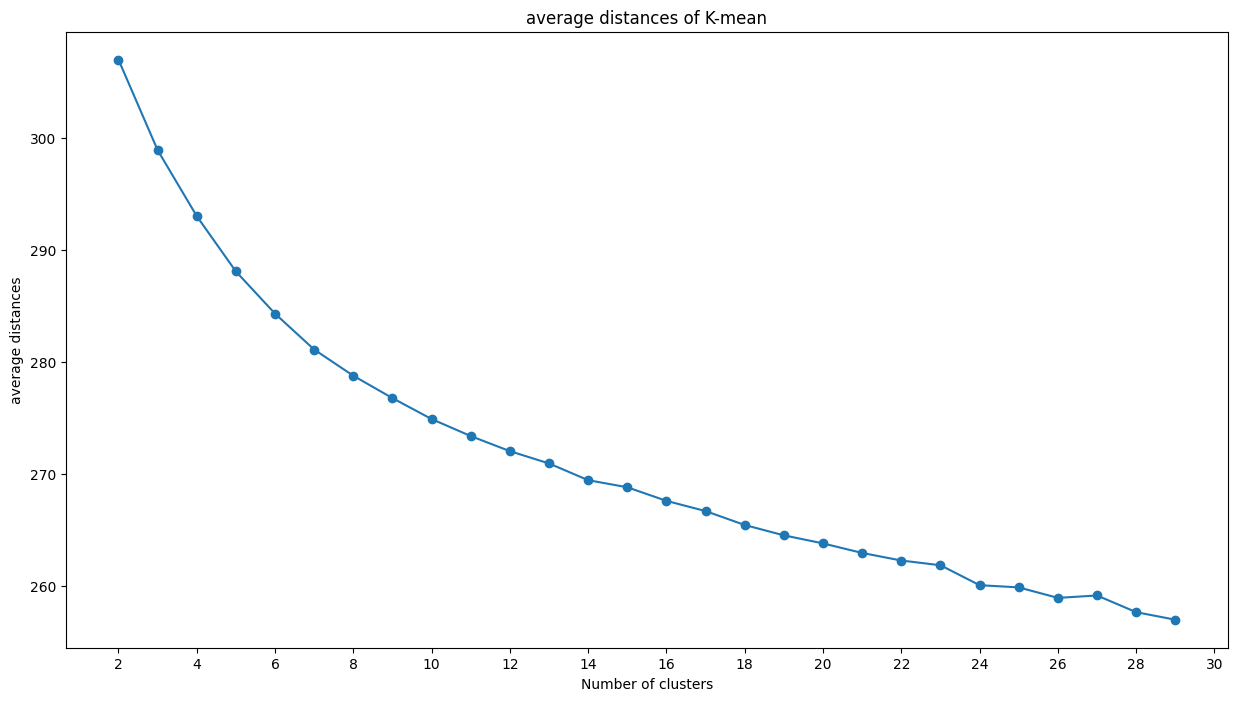

In [116]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(15,8)) 
plt.title('average distances of K-mean')
plt.xlabel('Number of clusters')
plt.ylabel('average distances')
plt.xticks([0,2,4,6,8,10,12,14,16,18,20,22,24,26,28],[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30])
plt.plot(kmeans_avg,marker='o')

In [117]:
def k_score(n,k,df):
    clusterer = KMeans(n_clusters=n,random_state=0).fit(df)
    s = df.sample(k)
    p = clusterer.predict(s)
    score = silhouette_score(s,p)
    return score

In [118]:
%%time

# find out the best number cluster 
k_list=[]
kmeans_score=[]
for i in range(15,20):
    print("for "+str(i)+" cluster")
    k_list.append(i)
    kmeans_score.append(k_score(i,10000,my_azdias_df))

for 15 cluster


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


for 16 cluster


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


for 17 cluster


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


for 18 cluster


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


for 19 cluster


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: total: 6min 24s
Wall time: 1min 32s


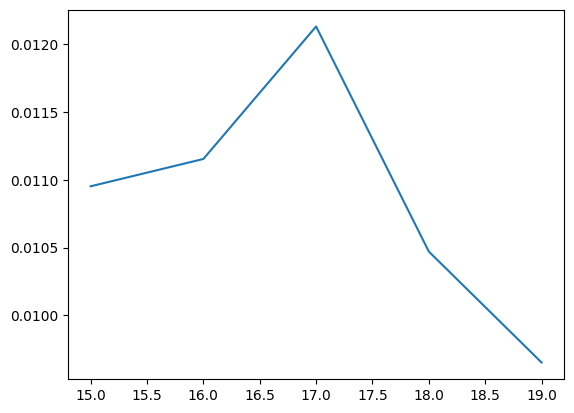

In [119]:
# find out the best number cluster 
plt.plot(k_list,kmeans_score)

- I think 17 is the best.

### Use my_azdias with PCA and Use the same parameter on my_customers

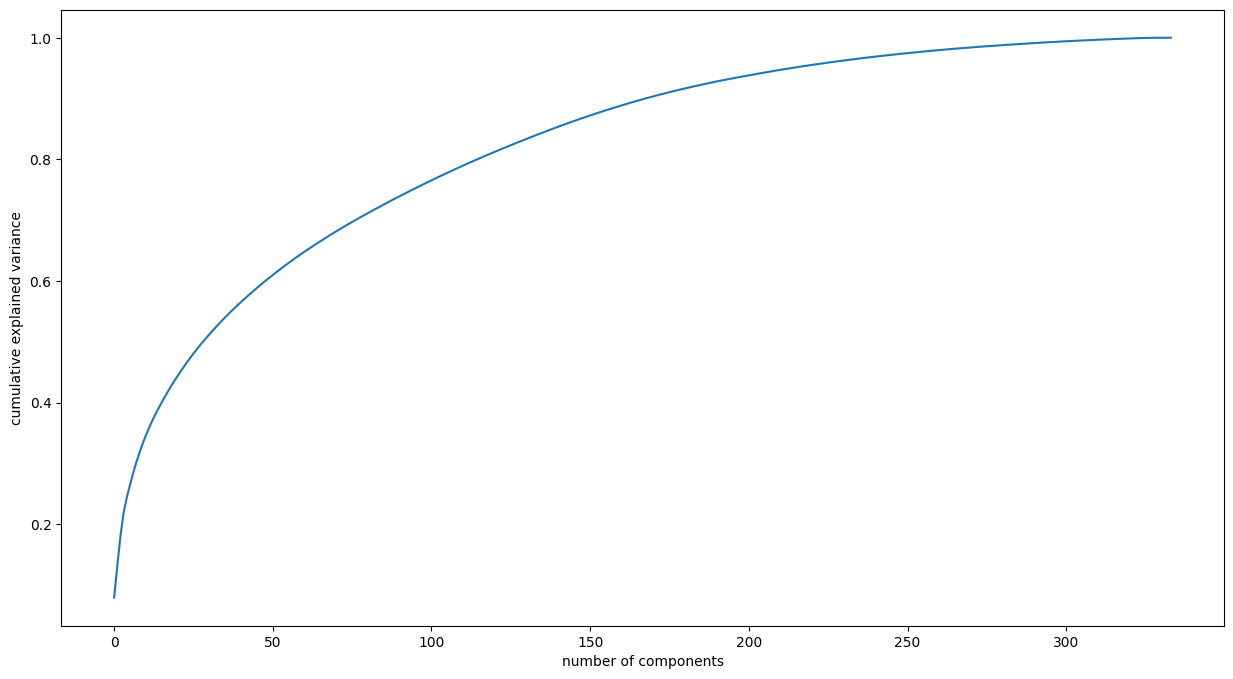

CPU times: total: 2.17 s
Wall time: 1.55 s


In [120]:
%%time
# Use the PCA to reduce the dimensions
plt.figure(figsize=(15,8)) 
pca = PCA().fit(my_azdias_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

CPU times: total: 250 ms
Wall time: 352 ms


<BarContainer object of 334 artists>

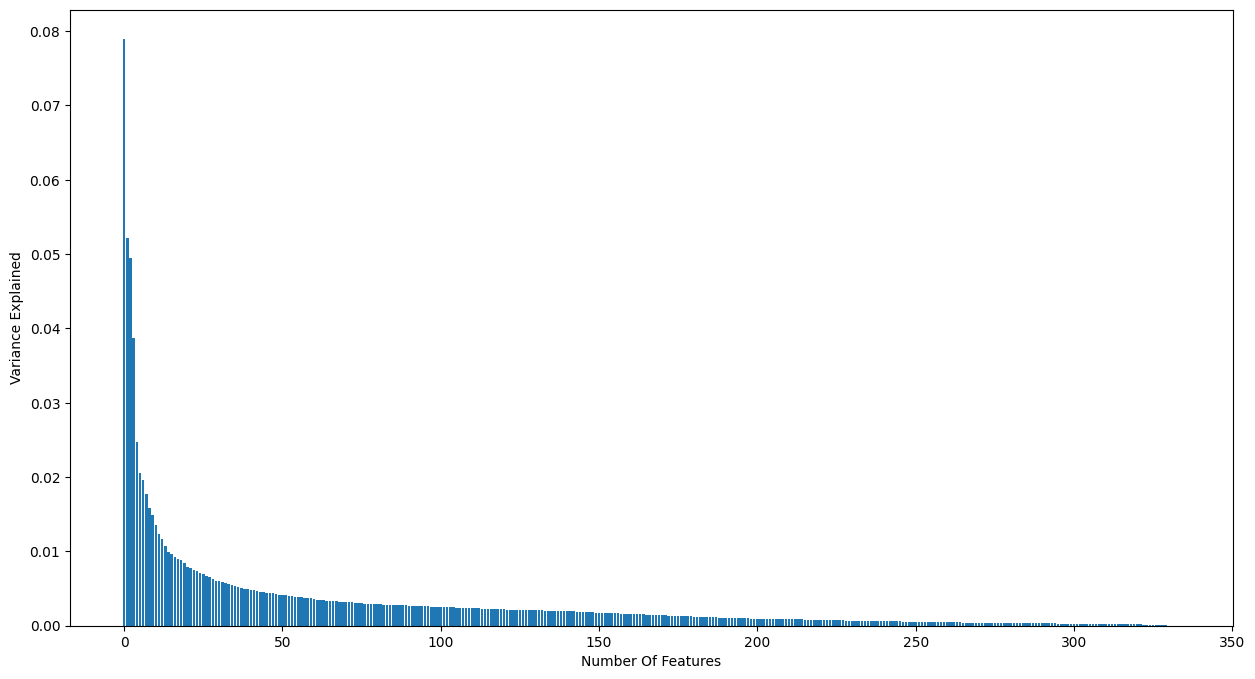

In [121]:
%%time
# Investigate the variance accounted for by each principal component.
plt.figure(figsize=(15,8)) 
explained_variance_ratio=[val for val in pca.explained_variance_ratio_]
cv=np.cumsum(np.round(explained_variance_ratio, decimals=3))
plt.ylabel('Variance Explained')
plt.xlabel('Number Of Features')
plt.bar(range(0,len(explained_variance_ratio)),explained_variance_ratio)

- I have done dimensionality reduction by getting explained ratio of principal components, As i observed 120 components/ eigen values were sufficient to explain more 80% variance in data so I opted that out. 

In [122]:
pca = PCA(n_components=120)
principalComponents_updated = pca.fit_transform(my_azdias_df)
first_comp=pca.components_[0]
first_comp_sorted=sorted(first_comp,reverse=True)
first_comp_index=sorted(range(len(first_comp)), key=lambda k: first_comp[k])

In [123]:
principalComponents_updated_df = pd.DataFrame(data=principalComponents_updated)

In [124]:
principalComponents_updated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28414 entries, 0 to 28413
Columns: 120 entries, 0 to 119
dtypes: float64(120)
memory usage: 26.0 MB


In [125]:
%%time

# find out the best number cluster 
PCA_k_list=[]
PCA_kmeans_score=[]
for i in range(15,20):
    print("for "+str(i)+" cluster")
    PCA_k_list.append(i)
    PCA_kmeans_score.append(k_score(i,10000,principalComponents_updated_df))

for 15 cluster


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


for 16 cluster


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


for 17 cluster


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


for 18 cluster


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


for 19 cluster


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: total: 2min 10s
Wall time: 38.1 s


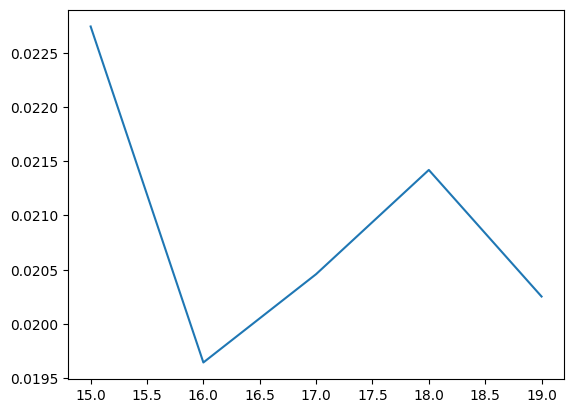

In [126]:
# find out the best number cluster with PCA
plt.plot(PCA_k_list,PCA_kmeans_score)

In [127]:
cols_sorted=my_azdias_df.columns[first_comp_index]
positive_index=first_comp_index[:10]
negative_index=first_comp_index[-10:]
positive_cols=cols_sorted[:10]
negative_cols=cols_sorted[-10:]
positive_weights=first_comp_sorted[:10]
negative_weights=first_comp_sorted[-10:]
for i in range(10):
    print('Positive: ',positive_index[i],positive_cols[i],positive_weights[i],' Negative: ',negative_index[i],negative_cols[i],negative_weights[i])

Positive:  137 PLZ8_ANTG3 0.1494070215945816  Negative:  117 LP_LEBENSPHASE_FEIN -0.10408724369599016
Positive:  281 HH_EINKOMMEN_SCORE 0.13907480329846886  Negative:  218 FINANZ_MINIMALIST -0.10638111867412774
Positive:  155 KBA13_ANTG4 0.13876450265875245  Negative:  118 KBA13_AUTOQUOTE -0.11490633057553618
Positive:  241 PLZ8_ANTG4 0.13867592500623857  Negative:  209 KBA05_GBZ -0.11575752872253478
Positive:  52 CAMEO_DEUG_2015 0.13668867920055489  Negative:  320 KBA05_AUTOQUOT -0.13065340415142362
Positive:  84 PLZ8_BAUMAX 0.1358862086563364  Negative:  125 MOBI_RASTER -0.13285350718128766
Positive:  62 EWDICHTE 0.13132616302406175  Negative:  61 KBA05_ANTG1 -0.13302533397142216
Positive:  20 ORTSGR_KLS9 0.12913423616892952  Negative:  237 LP_STATUS_FEIN -0.13408082845387856
Positive:  286 FINANZ_HAUSBAUER 0.11916395239605052  Negative:  287 PLZ8_ANTG1 -0.13435953949644652
Positive:  221 VK_DISTANZ 0.11330044363564186  Negative:  65 MOBI_REGIO -0.1376158447758602


In [128]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def weightsOfPca(componentIndex):
    components=pca.components_[componentIndex]
    componentspd=pd.DataFrame(components,columns=['weight'])
    componentspd['name']=list(my_azdias_df.columns)
    print(componentspd.sort_values(by='weight',ascending=False))

In [129]:
# weightsOfPca(0)

In [130]:
# weightsOfPca(1)

In [131]:
def pca_analysis(ind):
    first_comp=pca.components_[ind]
    first_comp_sorted=sorted(first_comp,reverse=True)
    first_comp_index=sorted(range(len(first_comp)), key=lambda k: first_comp[k])
    cols_sorted=scaled_df.columns[first_comp_index]
    positive_index=first_comp_index[:10]
    negative_index=first_comp_index[-10:]
    positive_cols=cols_sorted[:10]
    negative_cols=cols_sorted[-10:]
    positive_weights=first_comp_sorted[:10]
    negative_weights=first_comp_sorted[-10:]
    for i in range(10):
        print('Positive: ',positive_index[i],positive_cols[i],positive_weights[i],' Negative: ',negative_index[i],negative_cols[i],negative_weights[i])

In [132]:
# pca_analysis(1)

In [133]:
# pca_analysis(2)

In [134]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans=KMeans(n_clusters=17, random_state=0)
AZDIAS_kmeans_17=kmeans.fit_predict(my_azdias_df)

C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [135]:
print(AZDIAS_kmeans_17)

[14 14 15 ...  3  3  3]


In [136]:
# Do it for CUSTOMERS

scaled = scaler.fit_transform(my_customers[list(numerical_attribute|multiple_categories_attribute)]) 
my_customers_scaled_df=pd.DataFrame(scaled, columns=list(numerical_attribute|multiple_categories_attribute),index=my_customers.index)

my_customers_df=pd.concat([my_customers_scaled_df, my_customers[list(binary_attribute)]], axis=1)

my_customers_df.shape


(23575, 334)

In [137]:
pca = PCA(n_components=120)
principalComponents_CUSTOMERS = pca.fit_transform(my_customers_df)
kmeans=KMeans(n_clusters=17, random_state=0)
CUSTOMERS_kmeans_17=kmeans.fit_predict(principalComponents_CUSTOMERS)

C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [138]:
print(CUSTOMERS_kmeans_17)

[ 1  0  8 ...  4  4 10]


In [139]:
AZDIAS_list=np.bincount(AZDIAS_kmeans_17)
print(AZDIAS_list)
CUSTOMERS_list=np.bincount(CUSTOMERS_kmeans_17)
print(CUSTOMERS_list)

[ 957 1537 2162 1674 1573  494 2446 1576 1447 2275   30 2239 1599 1649
 2205 2692 1859]
[1860 1836  933  783 1687 1869  487 1372 1892 1075 1661 1580 2301 1441
  748 2008   42]


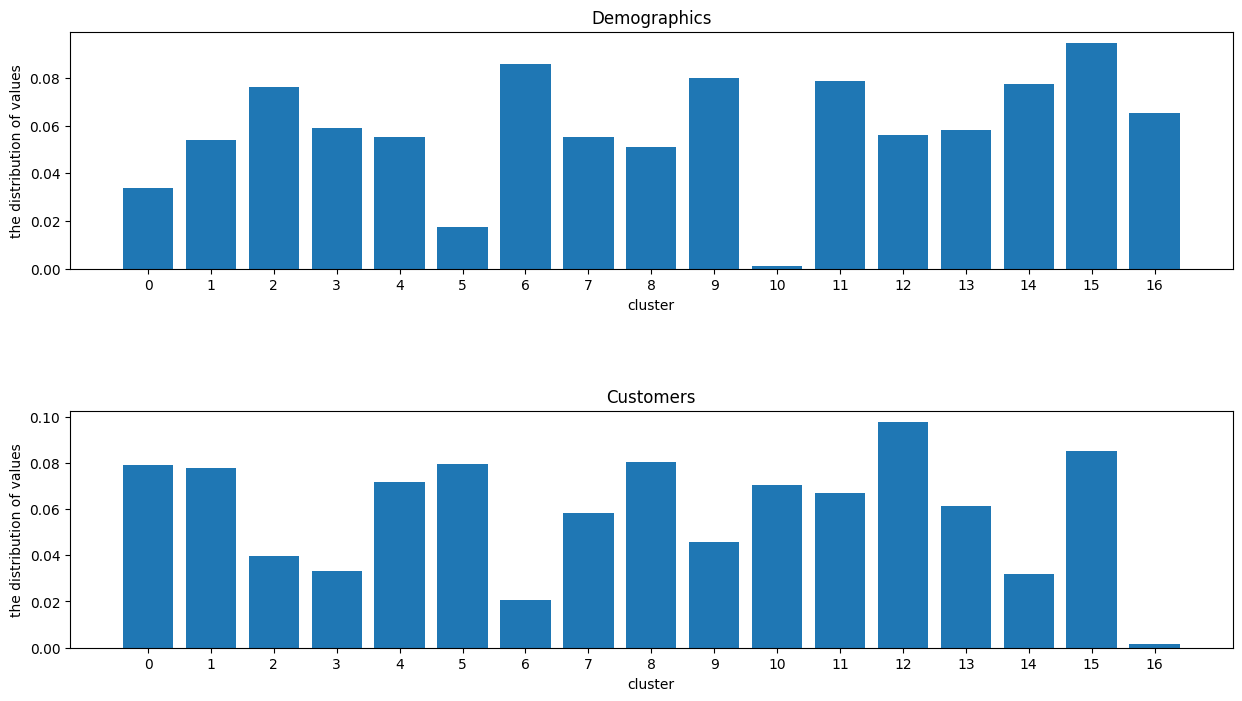

In [140]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.


percent_bin_list = list(map(lambda i: i/len(AZDIAS_kmeans_17), AZDIAS_list)) 
customers_percent_bin_list = list(map(lambda i: i/len(CUSTOMERS_kmeans_17), CUSTOMERS_list)) 
plt.figure(figsize=(15,8)) 
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.6)

ax1=plt.subplot(211)
plt.bar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],percent_bin_list)
ax1.set_title('Demographics')
ax1.set_xlabel('cluster')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
ax1.set_ylabel('the distribution of values')

ax2=plt.subplot(212)
plt.bar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],customers_percent_bin_list)
ax2.set_title('Customers')
ax2.set_xlabel('cluster')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
ax2.set_ylabel('the distribution of values')
plt.show()

In [141]:
overrepresented=kmeans.cluster_centers_[8]
print(overrepresented)

[-2.69183962e+00 -2.04466115e+00 -4.16400897e+00  3.11233433e+00
 -2.48526420e-01  1.04099892e+00 -2.30290136e-01  4.81966775e-02
  2.29454781e-02  1.24264180e-01 -5.27634233e-06 -1.25730109e-01
  7.49865835e-01 -9.07283852e-02 -1.33710490e-02  1.99709012e-01
  1.59089806e-01 -1.72966136e-01  3.89230334e-02  1.87900188e-01
 -4.08230241e-02  5.09029082e-02  1.86975207e-02 -2.15460206e-01
 -6.52647686e-02  9.58470646e-04 -1.49732231e-01  1.96230241e-02
 -2.83064874e-02  2.16436647e-01 -1.50918744e-01  8.79140040e-03
  8.50103302e-03 -5.16926676e-02  4.10678477e-02 -7.29883136e-02
  1.63331286e-01  7.30401436e-02 -5.55112242e-02  6.94645019e-02
 -2.14577905e-01  7.79185453e-02 -1.53697417e-02  1.08435185e-01
 -1.00251970e-02  7.40949757e-02 -6.95004570e-02 -2.90801976e-02
  1.48161123e-01 -5.60645741e-02  5.23293431e-02 -8.34259940e-02
  2.04323813e-02  8.43507765e-02  2.50097539e-03  5.56659066e-02
 -3.00355209e-02 -3.52011963e-03 -4.97153130e-03 -3.30558865e-02
  4.84535882e-02 -1.40493

In [142]:
# check the details
overrepresentedpd=pd.DataFrame(overrepresented,columns=['weight'])
# overrepresentedpd['rank']=overrepresentedpd.index
print(overrepresentedpd.sort_values(by='weight',ascending=False))

      weight
3   3.112334
5   1.040999
12  0.749866
29  0.216437
15  0.199709
..       ...
6  -0.230290
4  -0.248526
1  -2.044661
0  -2.691840
2  -4.164009

[120 rows x 1 columns]


In [143]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
underrepresented=kmeans.cluster_centers_[14]
print(underrepresented)

[ 2.15395347e+00 -6.59181593e+00 -6.82528863e-01 -2.64690538e+00
  4.33898993e+00  9.17871559e-01 -1.15977888e+00 -4.40082829e-01
  2.89438032e+00 -3.18713135e-01 -4.21164911e-01  3.67140163e-02
 -4.60589492e-01  2.36228934e+00 -6.18938076e-01  2.13875185e-01
 -5.12132517e-01  1.25789609e-01 -2.60422416e-01  1.57488538e-01
  1.17531530e+00 -8.59396457e-01  4.30880618e-01  3.21183142e-01
 -2.66539664e-01  1.24969352e-01 -7.78618528e-01  4.53205037e-01
  9.01807651e-02 -6.41374327e-02  1.41858971e-01  1.92199419e-01
 -2.14950140e-01 -3.82667433e-01  1.14688149e-01  5.29808954e-02
  5.33790485e-01 -1.83786920e-01 -1.42451525e-01 -2.11188418e-01
 -1.06618219e-01 -4.13471029e-01 -1.48512053e-01 -2.52872589e-01
  2.25330021e-01  4.49735902e-02  2.23772550e-01  2.93507683e-01
 -8.70539179e-02  1.84016697e-01 -7.69526512e-02 -3.39961347e-01
 -3.98957203e-02 -1.68794520e-01  1.61026680e-01 -1.57242087e-02
 -1.83068244e-01 -9.93123868e-02 -2.93859323e-01 -1.21908946e-01
 -3.22798363e-03 -4.28209

In [144]:
# check the details
underrepresentedpd=pd.DataFrame(underrepresented,columns=['weight'])
# overrepresentedpd['rank']=overrepresentedpd.index
print(underrepresentedpd.sort_values(by='weight',ascending=False))

      weight
4   4.338990
8   2.894380
13  2.362289
0   2.153953
20  1.175315
..       ...
26 -0.778619
21 -0.859396
6  -1.159779
3  -2.646905
1  -6.591816

[120 rows x 1 columns]


In [145]:
weightsOfPca(0)

       weight                  name
62   0.155782              EWDICHTE
137  0.151838            PLZ8_ANTG3
20   0.148029           ORTSGR_KLS9
155  0.143239           KBA13_ANTG4
241  0.140388            PLZ8_ANTG4
..        ...                   ...
287 -0.141196            PLZ8_ANTG1
125 -0.141219           MOBI_RASTER
118 -0.146219       KBA13_AUTOQUOTE
91  -0.146403  KBA13_ALTERHALTER_60
65  -0.152391            MOBI_REGIO

[334 rows x 2 columns]


In [146]:
weightsOfPca(2)

       weight                   name
93   0.194540  PRAEGENDE_JUGENDJAHRE
107  0.192406              CJT_TYP_2
227  0.185845              CJT_TYP_1
179  0.178736          FINANZ_SPARER
254  0.154422   ALTERSKATEGORIE_FEIN
..        ...                    ...
313 -0.174493      CJT_KATALOGNUTZER
294 -0.179859              CJT_TYP_6
2   -0.183251              CJT_TYP_5
282 -0.184576              CJT_TYP_4
183 -0.187700              CJT_TYP_3

[334 rows x 2 columns]


- I computed the percentage of all 17 clusters of the two datasets which were the demographics data and the customers data.
- I drawed the percentage of the clusters pictures for each data.
- I found the overrepresented cluster 8 and the underrepresented cluster 14.
- The cluster 8 contained component 0 which was the top1 components
- The cluster 14 contained component 0 and component 2 which were the top2 components
- The component 0 contained KBA13_ANTG3,PLZ8_ANTG3,KBA13_BAUMAX,KBA13_ANTG4,PLZ8_BAUMAX,EWDICHTE,PLZ8_ANTG4 which were the top7 features of it.All of them meaned the cars level.
- The component 2 contained D19_GESAMT_ANZ_24,D19_GESAMT_ANZ_12 which were the top2 features of it.All of them meaned household and family homes.

- I suggest the cluster 3,5,6,7,8,9,15 of the general population that are more likely to be part of the mail-order company's main customer base,

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### metrics
Use the roc_auc_score to get best result of Supervised Learning

In [148]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\AVELL\AppData\Local\Temp\ipykernel_9596\3492614913.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


In [149]:
print(mailout_train.shape)

(31724, 367)


In [150]:
mailout_train['RESPONSE'].value_counts()

RESPONSE
0.0    31321
1.0      402
Name: count, dtype: int64

In [151]:
print(set(azdias)-set(mailout_train),set(mailout_train)-set(azdias))

set() {'RESPONSE'}


In [152]:
print(mailout_train['RESPONSE'].isnull().sum())

1


- I would deal with the mailout_train dataset with the method that use in the unsupervised section.

In [153]:
mailout_train=unknown2missing(mailout_train)

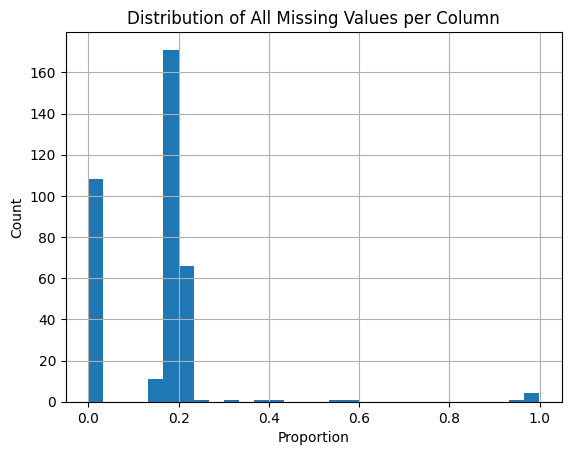

In [154]:
mailout_train_col_null=(mailout_train.isnull().sum()/len(mailout_train)).sort_values(ascending=False)
mailout_train_col_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Column');


In [155]:
mailout_train_remove_features=set(mailout_train_col_null[mailout_train_col_null>0.3].index)
print(mailout_train_remove_features)

{'KK_KUNDENTYP', 'ALTER_HH', 'ALTER_KIND1', 'TITEL_KZ', 'KBA05_BAUMAX', 'ALTER_KIND2', 'AGER_TYP', 'EXTSEL992', 'ALTER_KIND4', 'ALTER_KIND3'}


In [156]:
mailout_train_df=mailout_train.drop(labels=mailout_train_remove_features,axis=1)

In [157]:
mailout_train_df.set_index('LNR',inplace=True)

In [158]:
mailout_train_df[list(numerical_attribute)]
mailout_train_df[list(multiple_categories_attribute)]
mailout_train_df[list(binary_attribute)]
mailout_train_df.drop(labels=(set(mailout_train_df.columns)-numerical_attribute-multiple_categories_attribute-binary_attribute-set(['RESPONSE'])),axis=1,inplace=True)

In [159]:
mailout_train_df.shape

(31724, 335)

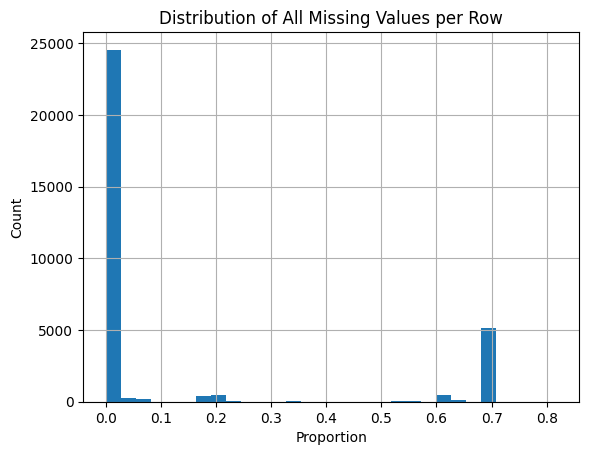

In [160]:
# deal with rows
mailout_train_row_null=(mailout_train_df.isnull().mean(axis=1)).sort_values(ascending=False)
mailout_train_row_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Row');

In [161]:
remove_mailout_train_rows=mailout_train_row_null[mailout_train_row_null>0.5].index
mailout_train_df.drop(index=remove_mailout_train_rows,axis=0,inplace=True)

In [162]:
mailout_train_df.shape

(25954, 335)

In [163]:
# deal with the numerical features
# deal with the 'MIN_GEBAEUDEJAHR' , 'GEBURTSJAHR'
mailout_train_df['MIN_GEBAEUDEJAHR']=2017-mailout_train_df['MIN_GEBAEUDEJAHR']
mailout_train_df['GEBURTSJAHR']=2017-mailout_train_df['GEBURTSJAHR']

# fill the missing data in numerical_attribute
for l in numerical_attribute:
    mailout_train_df[l]=mailout_train_df[l].fillna(value=round(mailout_train_df[l].mean()))

In [164]:
# deal with the multiple categories features
# deal with the 'CAMEO_DEUG_2015',replace the X value by np.nan
mailout_train_df['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)

mailout_train_df['CAMEO_DEUG_2015']=mailout_train_df['CAMEO_DEUG_2015'].astype('float')

mailout_train_df[list(multiple_categories_attribute)]=mailout_train_df[list(multiple_categories_attribute)].astype('float')

for l in multiple_categories_attribute:
    mailout_train_df[l].fillna(mailout_train_df[l].mode()[0], inplace=True)
    
mailout_train_df[list(multiple_categories_attribute)]=mailout_train_df[list(multiple_categories_attribute)].astype('int')

In [165]:
# deal with the binary features
mailout_train_df.loc[mailout_train_df['OST_WEST_KZ'] =='W','OST_WEST_KZ']=1
mailout_train_df.loc[mailout_train_df['OST_WEST_KZ'] =='O','OST_WEST_KZ']=0
# ANREDE_KZ
mailout_train_df['ANREDE_KZ']=mailout_train_df['ANREDE_KZ']-1
# VERS_TYP
mailout_train_df['VERS_TYP']=mailout_train_df['VERS_TYP']-1


for l in binary_attribute:
    mailout_train_df[l].fillna(mailout_train_df[l].mode()[0], inplace=True)

mailout_train_df[list(binary_attribute)]=mailout_train_df[list(binary_attribute)].astype('int')

In [166]:
scaled = scaler.fit_transform(mailout_train_df[list(numerical_attribute|multiple_categories_attribute)]) 
mailout_train_df_scaled_df=pd.DataFrame(scaled, columns=list(numerical_attribute|multiple_categories_attribute),index=mailout_train_df.index)

my_mailout_train_df=pd.concat([mailout_train_df_scaled_df, mailout_train_df[list(binary_attribute|set(['RESPONSE']))]], axis=1)


my_mailout_train_df.shape

(25954, 335)

In [167]:
(my_mailout_train_df.isnull().sum()).sum()

0

In [168]:
my_mailout_train_df.to_pickle("my_mailout_train_df.pkl")

In [169]:
X = my_mailout_train_df.drop('RESPONSE',axis=1)
y = my_mailout_train_df['RESPONSE']

In [170]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.05, random_state=0)

In [171]:
y_val.value_counts()

RESPONSE
0.0    1281
1.0      17
Name: count, dtype: int64

### Algorithm comparison
I would choose several common algorithms to implement supervised learning, and choose the best ones for the next optimization.

In [172]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_preds = clf.predict_proba(X_val)
score = metrics.roc_auc_score(y_val,y_preds[:,1])
print(score)

0.6564265050282407


C:\Users\AVELL\anaconda3\envs\gpu2\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [173]:
print(y_preds)

[[9.85741459e-01 1.42585409e-02]
 [9.99839157e-01 1.60842736e-04]
 [9.90350547e-01 9.64945267e-03]
 ...
 [9.98383653e-01 1.61634745e-03]
 [9.47714187e-01 5.22858130e-02]
 [9.98949451e-01 1.05054937e-03]]


In [174]:
# DecisionTreeClassifier
from sklearn import tree
clf = tree.DecisionTreeClassifier().fit(X_train, y_train)
y_preds = clf.predict_proba(X_val)
score = metrics.roc_auc_score(y_val, y_preds[:,1])
print(score)

0.4879000780640125


In [179]:
# Simple network
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.utils.data
from torch.autograd import Variable
torch.set_default_dtype(torch.float64)

In [180]:
torch_tensor_X_train = torch.tensor(X_train.values)
torch_tensor_y_train = torch.tensor(y_train.values,dtype=torch.long)
torch_tensor_X_val = torch.tensor(X_val.values)
torch_tensor_y_val = torch.tensor(y_val.values,dtype=torch.long)

In [181]:
train_batch_size =35094
test_batch_size =35094

In [182]:
train = torch.utils.data.TensorDataset(torch_tensor_X_train,torch_tensor_y_train)
test = torch.utils.data.TensorDataset(torch_tensor_X_val,torch_tensor_y_val)

train_loader = torch.utils.data.DataLoader(train, batch_size = train_batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = test_batch_size, shuffle = False)

In [183]:
class NetSimple(torch.nn.Module):  # simpleNet
    def __init__(self, in_dim, n_hidden_1, out_dim): 
        super(NetSimple, self).__init__()  
        self.layer1 = nn.Linear(in_dim, n_hidden_1)
        self.layer2 = nn.Linear(n_hidden_1, out_dim)
 
    def forward(self, x): 
        x = self.layer1(x)
        x = self.layer2(x)
        return x

In [186]:
model = NetSimple(in_dim=334, n_hidden_1=120, out_dim=2)  # two classification has two n_features
if torch.cuda.is_available():
    model = model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)  
criterion = torch.nn.CrossEntropyLoss()  # loss_function

In [187]:
epochs =300
train_losses, test_losses = [] ,[]
for epoch in range(epochs):
    running_loss = 0
    for x1,y1 in train_loader:
        if torch.cuda.is_available():
            x1 = x1.cuda()
            y1 = y1.cuda()
        else:
            x1 = Variable(x1)
            y1= Variable(y1)
        out = model(x1)  
        loss = criterion(out, y1)  
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad(): #Turning off gradients to speed up
            model.eval()
            for x2,y2 in test_loader:
                if torch.cuda.is_available():
                    x2 = x2.cuda()
                    y2 = y2.cuda()
                else:
                    x2 = Variable(x2)
                    y2= Variable(y2)
                log_ps = model(x2)
                test_loss += criterion(log_ps,y2)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == y2.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train()        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

        prediction = torch.max(out, 1)[1].cpu()  ##返回每一行中最大值的那个元素，且返回其索引  torch.max()[1]， 只返回最大值的每个索引
#         pred_y = prediction.data.numpy().squeeze()
#         target_y = y_train_Variable.data.numpy()
        print(accuracy)

Epoch: 1/300..  Training Loss: 0.712..  Test Loss: 0.703..  Test Accuracy: 0.499
tensor(0.4992, dtype=torch.float32)
Epoch: 2/300..  Training Loss: 0.705..  Test Loss: 0.697..  Test Accuracy: 0.514
tensor(0.5139, dtype=torch.float32)
Epoch: 3/300..  Training Loss: 0.699..  Test Loss: 0.691..  Test Accuracy: 0.524
tensor(0.5239, dtype=torch.float32)
Epoch: 4/300..  Training Loss: 0.693..  Test Loss: 0.685..  Test Accuracy: 0.539
tensor(0.5393, dtype=torch.float32)
Epoch: 5/300..  Training Loss: 0.687..  Test Loss: 0.679..  Test Accuracy: 0.550
tensor(0.5501, dtype=torch.float32)
Epoch: 6/300..  Training Loss: 0.681..  Test Loss: 0.673..  Test Accuracy: 0.561
tensor(0.5609, dtype=torch.float32)
Epoch: 7/300..  Training Loss: 0.675..  Test Loss: 0.667..  Test Accuracy: 0.574
tensor(0.5740, dtype=torch.float32)
Epoch: 8/300..  Training Loss: 0.669..  Test Loss: 0.661..  Test Accuracy: 0.586
tensor(0.5863, dtype=torch.float32)
Epoch: 9/300..  Training Loss: 0.663..  Test Loss: 0.655..  Test

Epoch: 71/300..  Training Loss: 0.413..  Test Loss: 0.409..  Test Accuracy: 0.962
tensor(0.9622, dtype=torch.float32)
Epoch: 72/300..  Training Loss: 0.411..  Test Loss: 0.406..  Test Accuracy: 0.963
tensor(0.9630, dtype=torch.float32)
Epoch: 73/300..  Training Loss: 0.408..  Test Loss: 0.403..  Test Accuracy: 0.964
tensor(0.9638, dtype=torch.float32)
Epoch: 74/300..  Training Loss: 0.405..  Test Loss: 0.401..  Test Accuracy: 0.967
tensor(0.9669, dtype=torch.float32)
Epoch: 75/300..  Training Loss: 0.402..  Test Loss: 0.398..  Test Accuracy: 0.969
tensor(0.9692, dtype=torch.float32)
Epoch: 76/300..  Training Loss: 0.400..  Test Loss: 0.395..  Test Accuracy: 0.969
tensor(0.9692, dtype=torch.float32)
Epoch: 77/300..  Training Loss: 0.397..  Test Loss: 0.393..  Test Accuracy: 0.970
tensor(0.9700, dtype=torch.float32)
Epoch: 78/300..  Training Loss: 0.394..  Test Loss: 0.390..  Test Accuracy: 0.970
tensor(0.9700, dtype=torch.float32)
Epoch: 79/300..  Training Loss: 0.392..  Test Loss: 0.38

Epoch: 141/300..  Training Loss: 0.268..  Test Loss: 0.266..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 142/300..  Training Loss: 0.267..  Test Loss: 0.265..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 143/300..  Training Loss: 0.265..  Test Loss: 0.263..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 144/300..  Training Loss: 0.264..  Test Loss: 0.262..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 145/300..  Training Loss: 0.262..  Test Loss: 0.261..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 146/300..  Training Loss: 0.261..  Test Loss: 0.259..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 147/300..  Training Loss: 0.260..  Test Loss: 0.258..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 148/300..  Training Loss: 0.258..  Test Loss: 0.256..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 149/300..  Training Loss: 0.257..  Test L

Epoch: 210/300..  Training Loss: 0.191..  Test Loss: 0.191..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 211/300..  Training Loss: 0.191..  Test Loss: 0.190..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 212/300..  Training Loss: 0.190..  Test Loss: 0.190..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 213/300..  Training Loss: 0.189..  Test Loss: 0.189..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 214/300..  Training Loss: 0.188..  Test Loss: 0.188..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 215/300..  Training Loss: 0.187..  Test Loss: 0.187..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 216/300..  Training Loss: 0.187..  Test Loss: 0.187..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 217/300..  Training Loss: 0.186..  Test Loss: 0.186..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 218/300..  Training Loss: 0.185..  Test L

Epoch: 279/300..  Training Loss: 0.148..  Test Loss: 0.149..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 280/300..  Training Loss: 0.148..  Test Loss: 0.149..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 281/300..  Training Loss: 0.147..  Test Loss: 0.148..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 282/300..  Training Loss: 0.147..  Test Loss: 0.148..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 283/300..  Training Loss: 0.146..  Test Loss: 0.147..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 284/300..  Training Loss: 0.146..  Test Loss: 0.147..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 285/300..  Training Loss: 0.145..  Test Loss: 0.146..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 286/300..  Training Loss: 0.145..  Test Loss: 0.146..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 287/300..  Training Loss: 0.144..  Test L

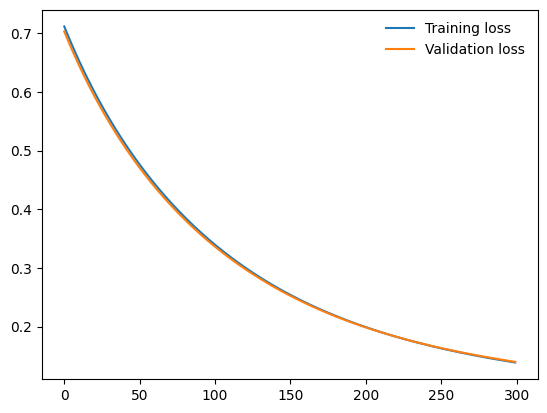

In [188]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### improving the algorithms
- From the results of the above three algorithms, the neural network works best, but it is likely to overfit, I will further optimize it.


In [189]:
class Net(torch.nn.Module):  # 3 layer net
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim): 
        super(Net, self).__init__()  
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1),nn.Dropout(0.5), nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2),nn.Dropout(0.5), nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
 
    def forward(self, x): 
#         x = F.relu(self.hidden(x)) 
#         x = self.out(x) 
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [192]:
model = Net(in_dim=334, n_hidden_1=120,n_hidden_2=10, out_dim=2)  # two classification has two n_features
if torch.cuda.is_available():
    model = model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)  
criterion = torch.nn.CrossEntropyLoss()  # loss_function

In [193]:
epochs =300
train_losses, test_losses = [] ,[]
for epoch in range(epochs):
    running_loss = 0
    for x1,y1 in train_loader:
        if torch.cuda.is_available():
            x1 = x1.cuda()
            y1 = y1.cuda()
        else:
            x1 = Variable(x1)
            y1= Variable(y1)
        out = model(x1)  
        loss = criterion(out, y1)  
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad(): #Turning off gradients to speed up
            model.eval()
            for x2,y2 in test_loader:
                if torch.cuda.is_available():
                    x2 = x2.cuda()
                    y2 = y2.cuda()
                else:
                    x2 = Variable(x2)
                    y2= Variable(y2)
                log_ps = model(x2)
                test_loss += criterion(log_ps,y2)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == y2.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train()        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

        prediction = torch.max(out, 1)[1].cpu()  ##返回每一行中最大值的那个元素，且返回其索引  torch.max()[1]， 只返回最大值的每个索引
#         pred_y = prediction.data.numpy().squeeze()
#         target_y = y_train_Variable.data.numpy()
        print(accuracy)

Epoch: 1/300..  Training Loss: 1.253..  Test Loss: 0.775..  Test Accuracy: 0.094
tensor(0.0940, dtype=torch.float32)
Epoch: 2/300..  Training Loss: 1.244..  Test Loss: 0.773..  Test Accuracy: 0.119
tensor(0.1186, dtype=torch.float32)
Epoch: 3/300..  Training Loss: 1.216..  Test Loss: 0.771..  Test Accuracy: 0.129
tensor(0.1294, dtype=torch.float32)
Epoch: 4/300..  Training Loss: 1.211..  Test Loss: 0.770..  Test Accuracy: 0.146
tensor(0.1456, dtype=torch.float32)
Epoch: 5/300..  Training Loss: 1.196..  Test Loss: 0.770..  Test Accuracy: 0.169
tensor(0.1687, dtype=torch.float32)
Epoch: 6/300..  Training Loss: 1.191..  Test Loss: 0.770..  Test Accuracy: 0.190
tensor(0.1903, dtype=torch.float32)
Epoch: 7/300..  Training Loss: 1.170..  Test Loss: 0.770..  Test Accuracy: 0.206
tensor(0.2057, dtype=torch.float32)
Epoch: 8/300..  Training Loss: 1.161..  Test Loss: 0.771..  Test Accuracy: 0.216
tensor(0.2157, dtype=torch.float32)
Epoch: 9/300..  Training Loss: 1.142..  Test Loss: 0.771..  Test

Epoch: 71/300..  Training Loss: 0.627..  Test Loss: 0.560..  Test Accuracy: 0.918
tensor(0.9176, dtype=torch.float32)
Epoch: 72/300..  Training Loss: 0.619..  Test Loss: 0.557..  Test Accuracy: 0.927
tensor(0.9268, dtype=torch.float32)
Epoch: 73/300..  Training Loss: 0.614..  Test Loss: 0.553..  Test Accuracy: 0.929
tensor(0.9291, dtype=torch.float32)
Epoch: 74/300..  Training Loss: 0.608..  Test Loss: 0.550..  Test Accuracy: 0.935
tensor(0.9353, dtype=torch.float32)
Epoch: 75/300..  Training Loss: 0.604..  Test Loss: 0.546..  Test Accuracy: 0.941
tensor(0.9407, dtype=torch.float32)
Epoch: 76/300..  Training Loss: 0.598..  Test Loss: 0.543..  Test Accuracy: 0.944
tensor(0.9438, dtype=torch.float32)
Epoch: 77/300..  Training Loss: 0.595..  Test Loss: 0.540..  Test Accuracy: 0.949
tensor(0.9492, dtype=torch.float32)
Epoch: 78/300..  Training Loss: 0.589..  Test Loss: 0.536..  Test Accuracy: 0.953
tensor(0.9530, dtype=torch.float32)
Epoch: 79/300..  Training Loss: 0.586..  Test Loss: 0.53

Epoch: 141/300..  Training Loss: 0.389..  Test Loss: 0.388..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 142/300..  Training Loss: 0.387..  Test Loss: 0.386..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 143/300..  Training Loss: 0.384..  Test Loss: 0.384..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 144/300..  Training Loss: 0.382..  Test Loss: 0.383..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 145/300..  Training Loss: 0.379..  Test Loss: 0.381..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 146/300..  Training Loss: 0.378..  Test Loss: 0.380..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 147/300..  Training Loss: 0.378..  Test Loss: 0.378..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 148/300..  Training Loss: 0.376..  Test Loss: 0.377..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 149/300..  Training Loss: 0.372..  Test L

Epoch: 210/300..  Training Loss: 0.287..  Test Loss: 0.303..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 211/300..  Training Loss: 0.286..  Test Loss: 0.302..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 212/300..  Training Loss: 0.285..  Test Loss: 0.301..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 213/300..  Training Loss: 0.284..  Test Loss: 0.300..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 214/300..  Training Loss: 0.283..  Test Loss: 0.299..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 215/300..  Training Loss: 0.281..  Test Loss: 0.298..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 216/300..  Training Loss: 0.281..  Test Loss: 0.297..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 217/300..  Training Loss: 0.279..  Test Loss: 0.296..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 218/300..  Training Loss: 0.279..  Test L

Epoch: 279/300..  Training Loss: 0.233..  Test Loss: 0.252..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 280/300..  Training Loss: 0.231..  Test Loss: 0.251..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 281/300..  Training Loss: 0.232..  Test Loss: 0.251..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 282/300..  Training Loss: 0.231..  Test Loss: 0.250..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 283/300..  Training Loss: 0.230..  Test Loss: 0.250..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 284/300..  Training Loss: 0.230..  Test Loss: 0.249..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 285/300..  Training Loss: 0.229..  Test Loss: 0.249..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 286/300..  Training Loss: 0.228..  Test Loss: 0.248..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 287/300..  Training Loss: 0.228..  Test L

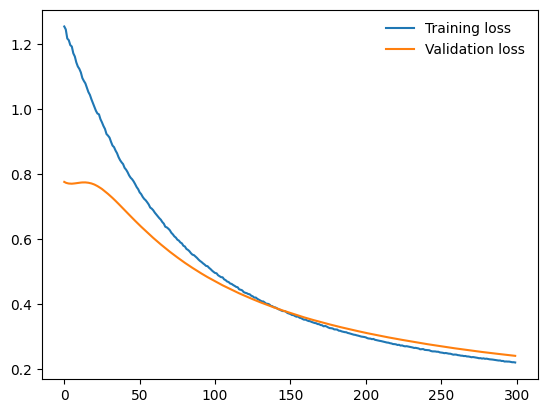

In [194]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [197]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\AVELL\AppData\Local\Temp\ipykernel_9596\137136989.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')


In [198]:
mailout_test.set_index('LNR',inplace=True)

In [199]:
mailout_test=unknown2missing(mailout_test)
mailout_test['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)

In [200]:
print(mailout_test.isnull().mean().mean())

0.14836878981051807


In [201]:
# dorp the features with mailout_train
mailout_test.drop(labels=list(set(mailout_test.columns)-set(mailout_train.columns)),axis=1,inplace=True)

In [202]:
mailout_test.shape

(32702, 365)

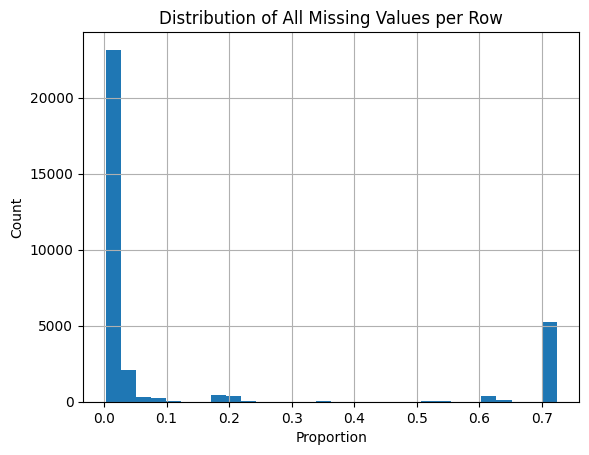

In [203]:
test_row_null=(mailout_test.isnull().mean(axis=1)).sort_values(ascending=False)
test_row_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Row');


In [204]:
remove_mailout_test_rows=test_row_null[test_row_null>0.5].index
len(remove_mailout_test_rows)

5890

In [205]:
# deal with the numerical features
# deal with the 'MIN_GEBAEUDEJAHR' , 'GEBURTSJAHR'
mailout_test['MIN_GEBAEUDEJAHR']=2017-mailout_test['MIN_GEBAEUDEJAHR']
mailout_test['GEBURTSJAHR']=2017-mailout_test['GEBURTSJAHR']

# fill the missing data in numerical_attribute
for l in numerical_attribute:
    mailout_test[l]=mailout_test[l].fillna(value=round(mailout_test[l].mean()))
	
# deal with the multiple categories features
# deal with the 'CAMEO_DEUG_2015',replace the X value by np.nan
mailout_test['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)

mailout_test['CAMEO_DEUG_2015']=mailout_test['CAMEO_DEUG_2015'].astype('float')

mailout_test[list(multiple_categories_attribute)]=mailout_test[list(multiple_categories_attribute)].astype('float')

for l in multiple_categories_attribute:
    mailout_test[l].fillna(mailout_test[l].mode()[0], inplace=True)
    
mailout_test[list(multiple_categories_attribute)]=mailout_test[list(multiple_categories_attribute)].astype('int')

# deal with the binary features
mailout_test.loc[mailout_test['OST_WEST_KZ'] =='W','OST_WEST_KZ']=1
mailout_test.loc[mailout_test['OST_WEST_KZ'] =='O','OST_WEST_KZ']=0
# ANREDE_KZ
mailout_test['ANREDE_KZ']=mailout_test['ANREDE_KZ']-1
# VERS_TYP
mailout_test['VERS_TYP']=mailout_test['VERS_TYP']-1


for l in binary_attribute:
    mailout_test[l].fillna(mailout_test[l].mode()[0], inplace=True)

mailout_test[list(binary_attribute)]=mailout_test[list(binary_attribute)].astype('int')

scaled = scaler.fit_transform(mailout_test[list(numerical_attribute|multiple_categories_attribute)]) 
mailout_train_df_scaled_df=pd.DataFrame(scaled, columns=list(numerical_attribute|multiple_categories_attribute),index=mailout_test.index)
my_mailout_test=pd.concat([mailout_train_df_scaled_df, mailout_test[list(binary_attribute)]], axis=1)

In [206]:
my_mailout_test.isnull().sum().sum()

0

In [207]:
my_mailout_test.shape

(32702, 334)

In [208]:
# ready for predict
test_dataset = torch.tensor(my_mailout_test.values)
new_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 42833, shuffle = False)

In [209]:
results = []
with torch.no_grad():
    model.eval()
    for t in new_test_loader:
        if torch.cuda.is_available():
            t = t.cuda()
        output = model(t)
        output=output.cpu()
        sm = torch.nn.Softmax()
        probabilities = sm(output) 
        print(probabilities.numpy()[:,1]) 
        results=probabilities.numpy()[:,1]
        #Converted to probabilities
#         ps = torch.exp(output)
#         top_p, top_class = ps.topk(1, dim = 1)
#         results += top_class.numpy().tolist()

[0.15735412 0.24371537 0.19974175 ... 0.20390152 0.2073641  0.25038886]


C:\Users\AVELL\AppData\Local\Temp\ipykernel_9596\4234465168.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = sm(output)


In [210]:
submissions=pd.DataFrame({"LNR": mailout_test.index,
                         "RESPONSE": results})
submissions.to_csv("my_submissions.csv", index=False, header=True)

In [211]:
submissions['RESPONSE'].value_counts()

RESPONSE
0.202125    1491
0.200715     924
0.206473     706
0.199707     604
0.204790     350
            ... 
0.210449       1
0.198423       1
0.173577       1
0.133238       1
0.250389       1
Name: count, Length: 28364, dtype: int64

## Conclusion
1. The difficulty of the dataset in this project  was that there are many dimensions, the description of each dimension was not clear, and the difficulty of cleaning was relatively large.
2. There were many features in this project that belong to category features. The use of PCA for dimensionality reduction was not particularly good. The Kmeans algorithm was not particularly effective for such features. The next step would be to try AUTOENCODING and K-prototype.
3. Supervised learning using neural networks was over-fitting. It was necessary to further increase the complexity of the dimensions. I would try to do the ONE-HOT processing of the category features.